# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'>Banking Data Analysis<br></div>

# <div style='padding:7px;background-color:Maroon;color:white;border-radius:2px;font-size:100%;text-align: center'>Regression Modeling<br></div>

## <span style="color:Aqua;">Importing libraries from Python</span>

In [15]:
import pandas as pd
pd.options.display.max_columns = 50
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)

import numpy as np
import os

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})

import scipy.stats as stats
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox

from category_encoders import TargetEncoder

from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score,root_mean_squared_error,max_error
import xgboost as xg

import pickle
import time



In [16]:
color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color

def univar_num(df, col):
    plt.figure(figsize=(16, 8))
    df = df.dropna(subset=[col])


    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode()[0]
    sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})
    plt.subplot(2, 3, 1)
    sns.histplot(data=df, x=col, kde=True, bins=50,color='maroon',fill=True)
    plt.title(f'Histogram for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

    
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df, x=col, color='lightgrey',legend=True)
    plt.xticks(rotation=45)
    plt.title(f'Box Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    plt.legend()
    plt.tight_layout()

    
    plt.subplot(2, 3, 3)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.gca().get_lines()[1].set_color('maroon')
    plt.gca().get_lines()[0].set_color('darkgreen')
    plt.title(f'QQ Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()

In [17]:
def kurtosis_color(kurt_val):
    if -1 <= kurt_val <= 1:
        kurt_color = color_good  # Dark Green for near-zero kurtosis (good)
    elif 1 < kurt_val <= 3 or -3 <= kurt_val < -1:
        kurt_color = color_okay  # Yellow for moderate kurtosis
    else:  # kurt_val > 3 or kurt_val < -3
        kurt_color = color_bad  # Maroon for extreme kurtosis
    return kurt_color

def skewness_color(skew_val):
    if -0.5 <= skew_val <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skew_val <= 0.5 or -0.5 < skew_val < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
    return color

In [18]:

# Defining a function to perform Box-Cox
def boxcox_transform(x):
    transformed_data,lmbda = boxcox(x + np.spacing(1))
    return transformed_data,lmbda

method_functions =  {
    'log': lambda x: np.log(x + np.spacing(1)),
    'square': np.sqrt,
    'rec': lambda x: np.where(x != 0, 1 / x, np.spacing(1)),
    'sig': lambda x: 1 / (1 + np.exp(-x)),
    'cube': lambda x: np.power(x, 3),
    'exp':lambda x: x**(1/5),
    'boxcox': boxcox_transform,
        }

def skewness_checker(df, column, method,pkl_path=None):
    transformed_columns = {}
    transformation_params = {}

    for method_name, func in method_functions.items():
        for col in column:

            new_column = f'{col}_{method_name}'
            if method_name == 'boxcox':
                transformed_values, lmbda = func(df[col])
                transformation_params[new_column] = lmbda 
            else:
                transformed_values = func(df[col])
            transformed_columns[new_column] = transformed_values
    normalized_df = pd.DataFrame(transformed_columns)
    if not os.path.exists(pkl_path):
        os.makedirs(pkl_path)
    file_path = os.path.join(pkl_path,'transformation_params.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(transformation_params, f)
        
    return normalized_df, transformation_params

def process_column(col):
    univar_num(df, col) 
    skew_val = df[col].skew()
    kurt = df[col].kurtosis()
    
    kurt_color = kurtosis_color(kurt)
    color = skewness_color(skew_val)
    
    skewed_col.append(col)
    
    print(f"\n\n{color}Skew for {col} is {skew_val:.4f}{color_neutral}")
    print(f"{color}Kurtosis for {col} is {kurt:.4f}{color_neutral}\n\n")


## <span style="color:Aqua;">Reading model dataset:</span>

In [19]:
df = pd.read_csv('/home/san/Downloads/insurance_reg.csv')
df.sample(3)

age     sex     bmi  children smoker     region  Preminum
419   30    male 25.5000         0     no  northeast 3645.0900
633   38    male 28.0000         1     no  northeast 6067.1300
911   48  female 27.3000         1     no  northeast 9447.2500

In [20]:
print(df.sex.value_counts(),df.smoker.value_counts())

sex
male      676
female    661
Name: count, dtype: int64 smoker
no     1064
yes     273
Name: count, dtype: int64


In [21]:
df.sex = df.sex.map({'male' : 1, 'female' : 0 })
df.smoker = df.smoker.map({'no': 0, 'yes' : 1})

In [22]:
print(df.sex.value_counts(),df.smoker.value_counts())

sex
1    676
0    661
Name: count, dtype: int64 smoker
0    1064
1     273
Name: count, dtype: int64


In [23]:
nominal = ['region']

ordinal = []

discrete = ['children','smoker','sex',]
continuous = ['age','bmi','Preminum',]

print(len(ordinal + nominal + discrete +continuous))
print(len(df.columns))


7
7


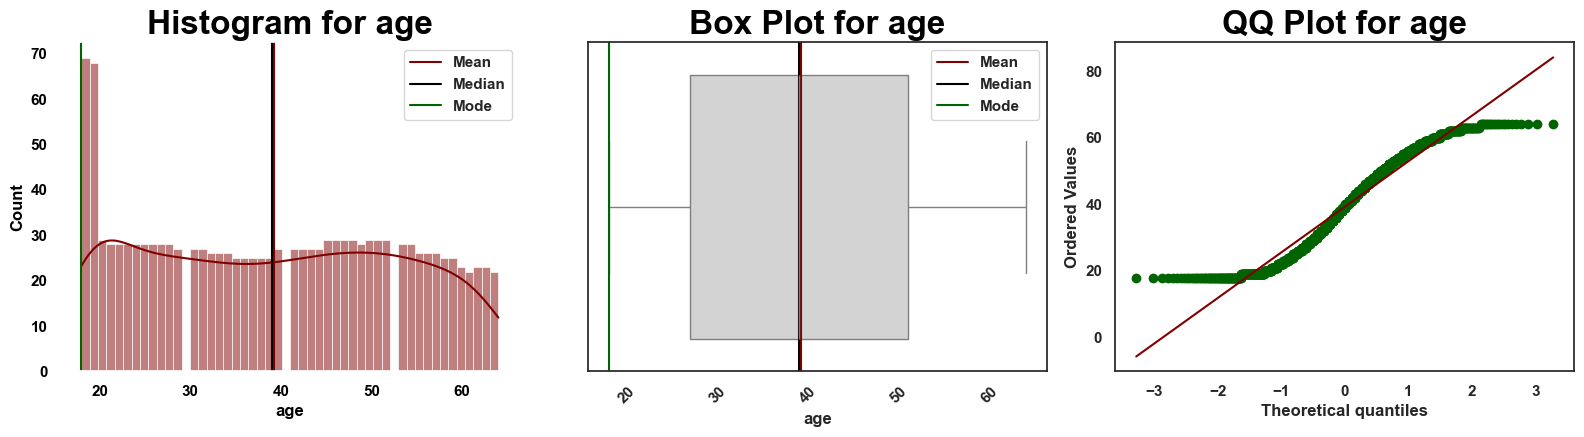



Skew for age is 0.0565
Kurtosis for age is -1.2442




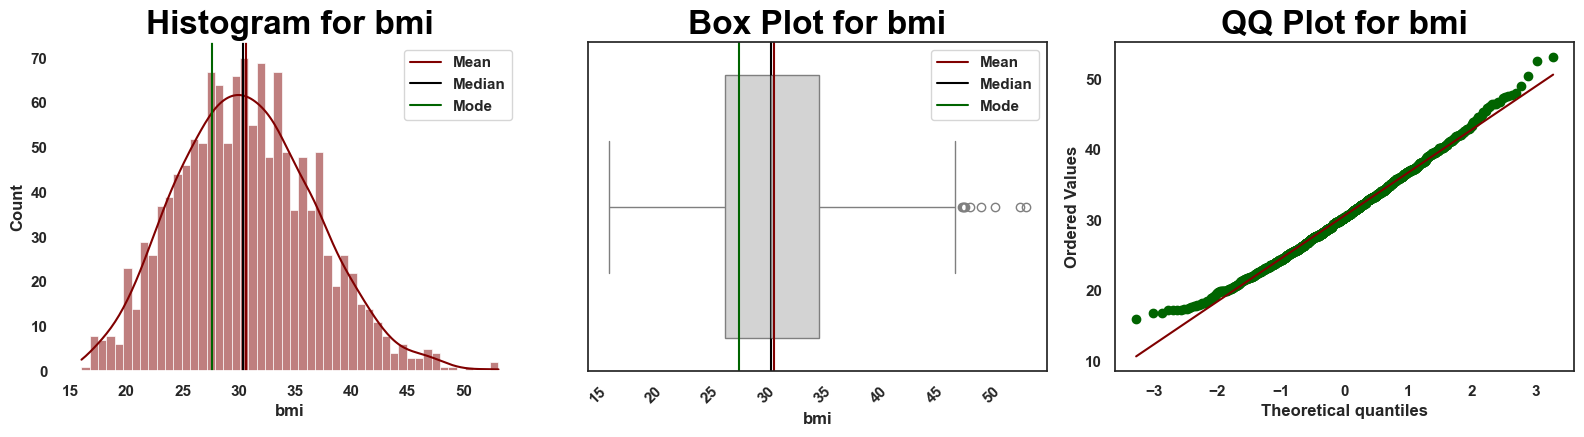



Skew for bmi is 0.2839
Kurtosis for bmi is -0.0555




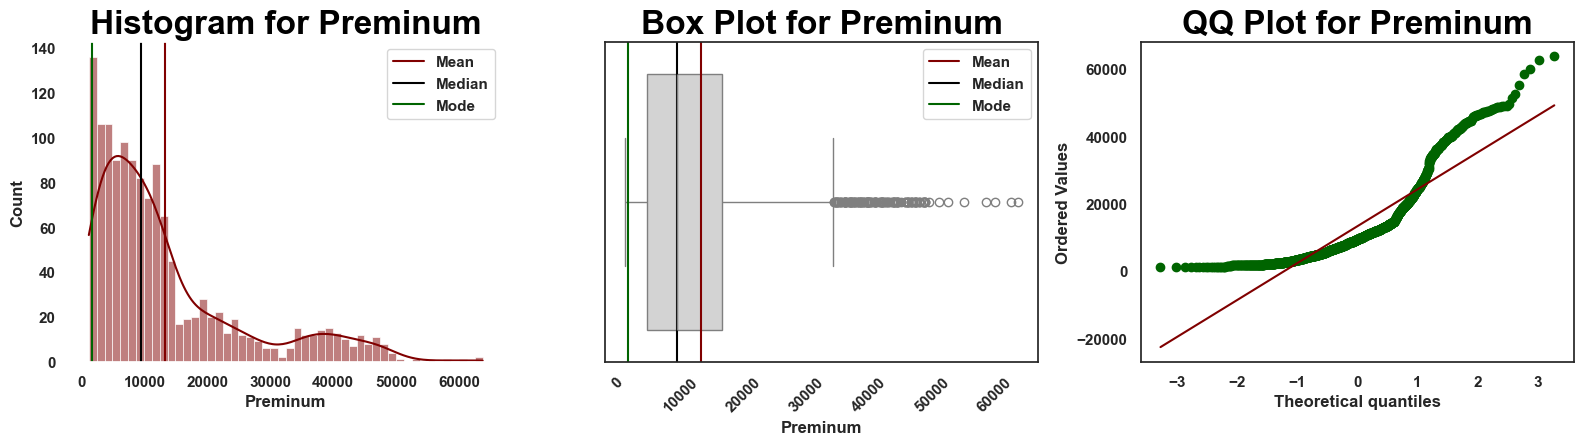



Skew for Preminum is 1.5195
Kurtosis for Preminum is 1.6185




In [24]:
skewed_col = []

_ = list(map(process_column, continuous))

In [25]:
normalized_df, params_reg = skewness_checker(df, continuous, method_functions,pkl_path='pkls/transformation_params.pkl')
normalized_df.sample(5)

age_log  bmi_log  Preminum_log  age_square  bmi_square  Preminum_square  \
985    3.9318   3.0727        9.1957      7.1414      4.6476          99.2730   
1188   4.0604   3.5086        9.4118      7.6158      5.7793         110.5966   
207    3.0910   3.1442        7.9128      4.6904      4.8166          52.2677   
1334   4.1589   3.2734        9.5746      8.0000      5.1381         119.9773   
134    2.9444   3.2465        7.9050      4.3589      5.0695          52.0656   

      age_rec  bmi_rec  Preminum_rec  age_sig  bmi_sig  Preminum_sig  \
985    0.0196   0.0463        0.0001   1.0000   1.0000        1.0000   
1188   0.0172   0.0299        0.0001   1.0000   1.0000        1.0000   
207    0.0455   0.0431        0.0004   1.0000   1.0000        1.0000   
1334   0.0156   0.0379        0.0001   1.0000   1.0000        1.0000   
134    0.0526   0.0389        0.0004   1.0000   1.0000        1.0000   

      age_cube   bmi_cube      Preminum_cube  age_exp  bmi_exp  Preminum_exp  \
985     132651 10077.6960  957165579074.4005   2.1954   1.8488        6.2912   
1188    195112 37259.7040 1829999099215.3225   2.2526   2.0172        6.5690   
207      10648 12487.1680   20389152001.9069   1.8556   1.8754        4.8674   
1334    262144 18399.7440 2982601163082.5303   2.2974   1.9245        6.7864   
134       6859 16974.5930   19920803410.3288   1.8020   1.9142        4.8598   

      age_boxcox  bmi_boxcox  Preminum_boxcox  
985      16.9456      6.7522          11.2820  
1188     18.4910      8.7313          11.6045  
207       9.3891      7.0501           9.4275  
1334     19.7603      7.6143          11.8495  
134       8.4306      7.4942           9.4167

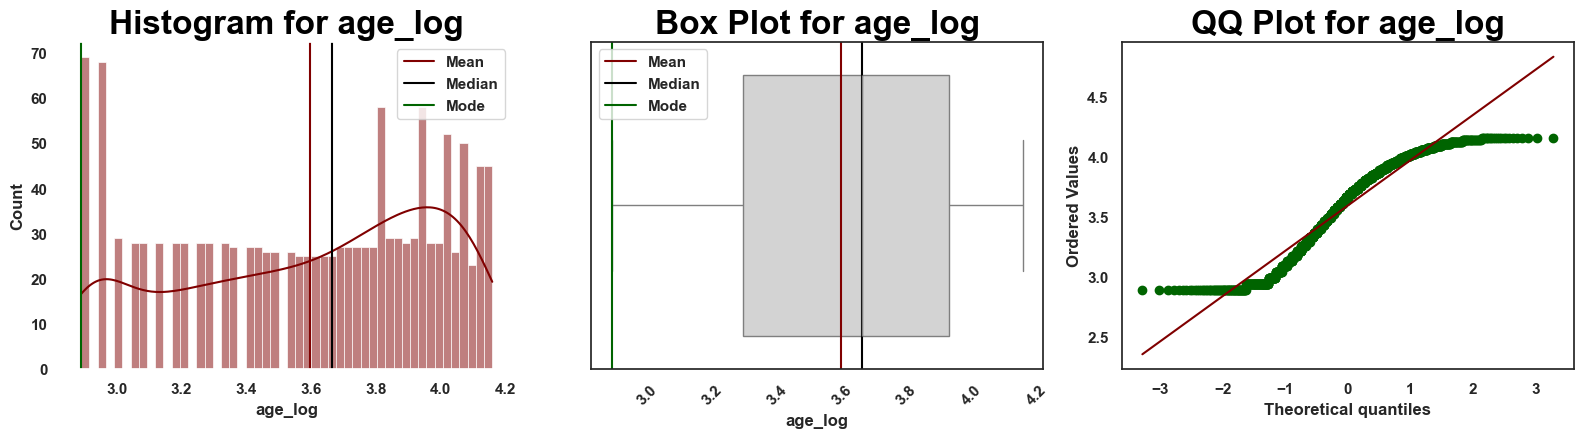



Skew for age_log is -0.37

Kurtosis for age_log is -1.12




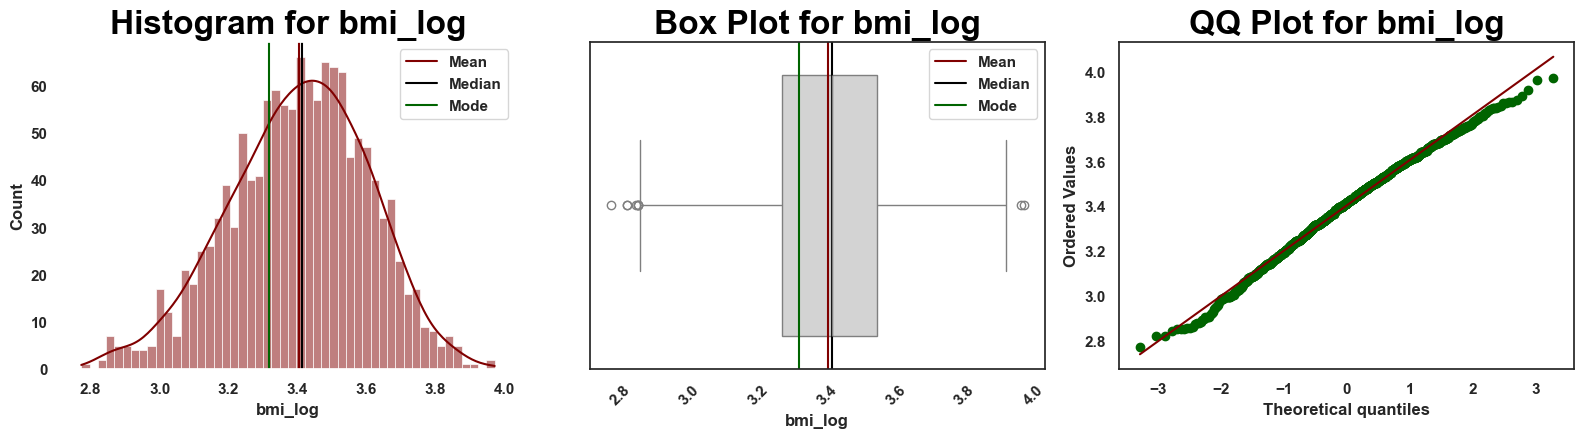



Skew for bmi_log is -0.26

Kurtosis for bmi_log is -0.14




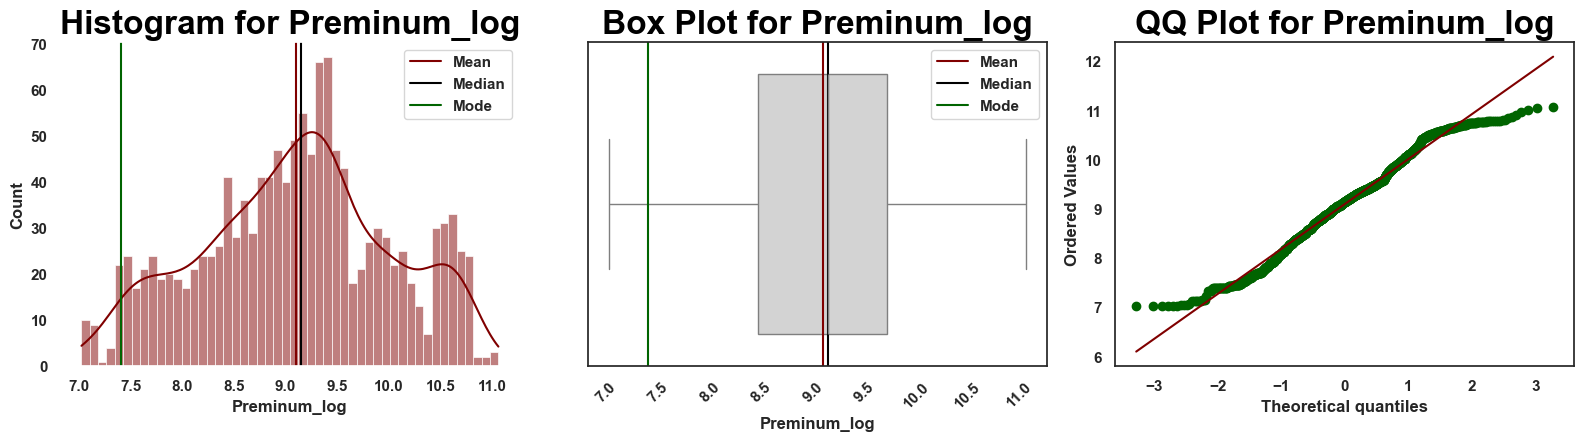



Skew for Preminum_log is -0.09

Kurtosis for Preminum_log is -0.63




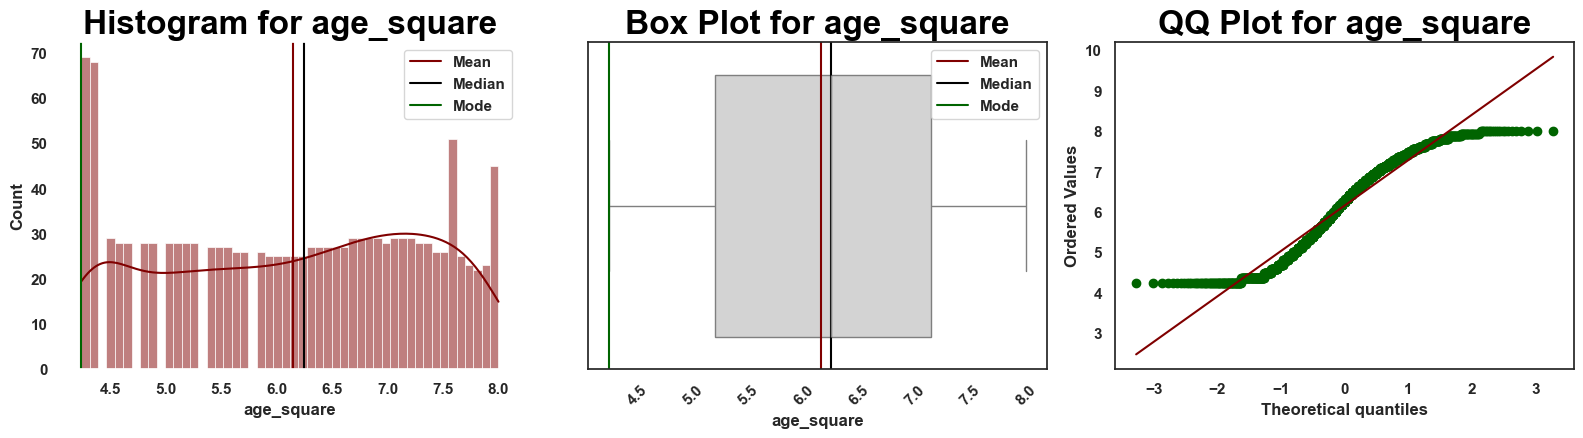



Skew for age_square is -0.16

Kurtosis for age_square is -1.23




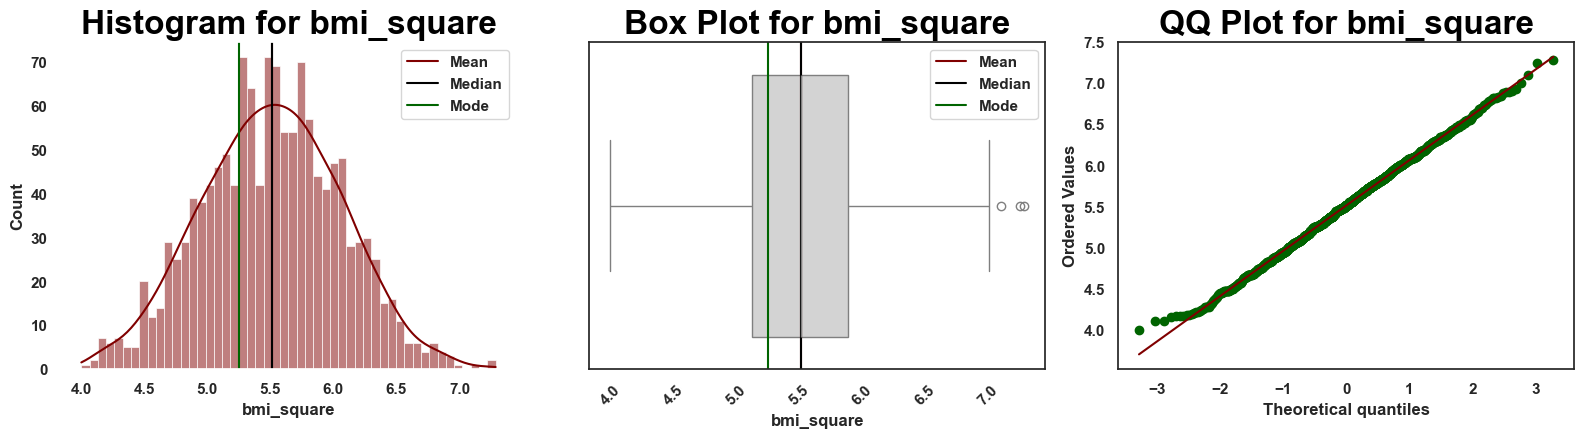



Skew for bmi_square is 0.01

Kurtosis for bmi_square is -0.21




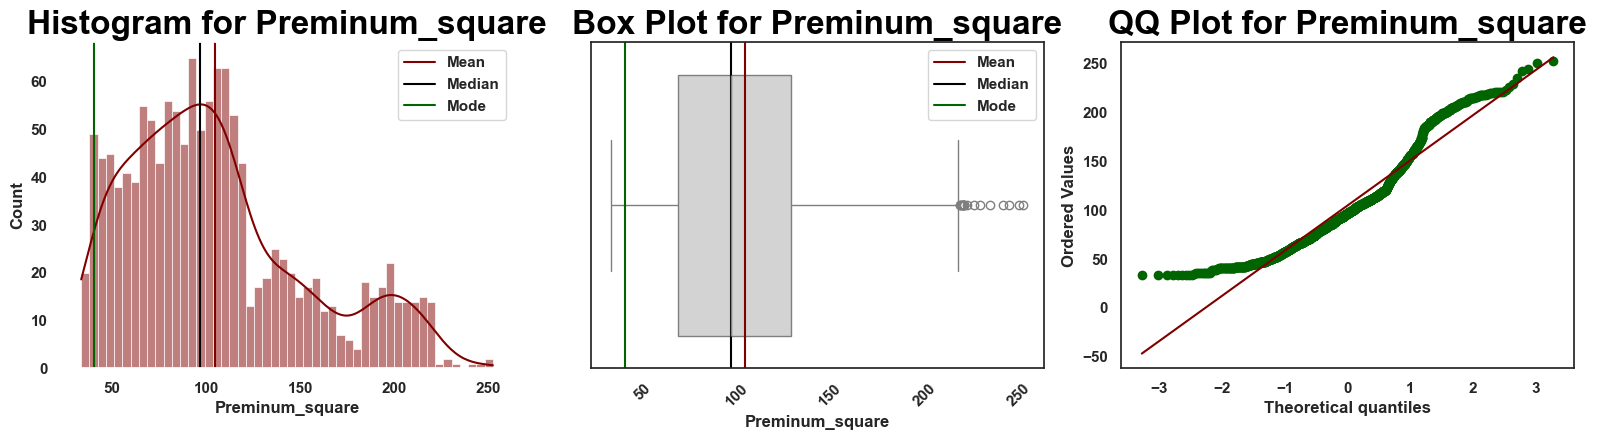



Skew for Preminum_square is 0.80

Kurtosis for Preminum_square is -0.07




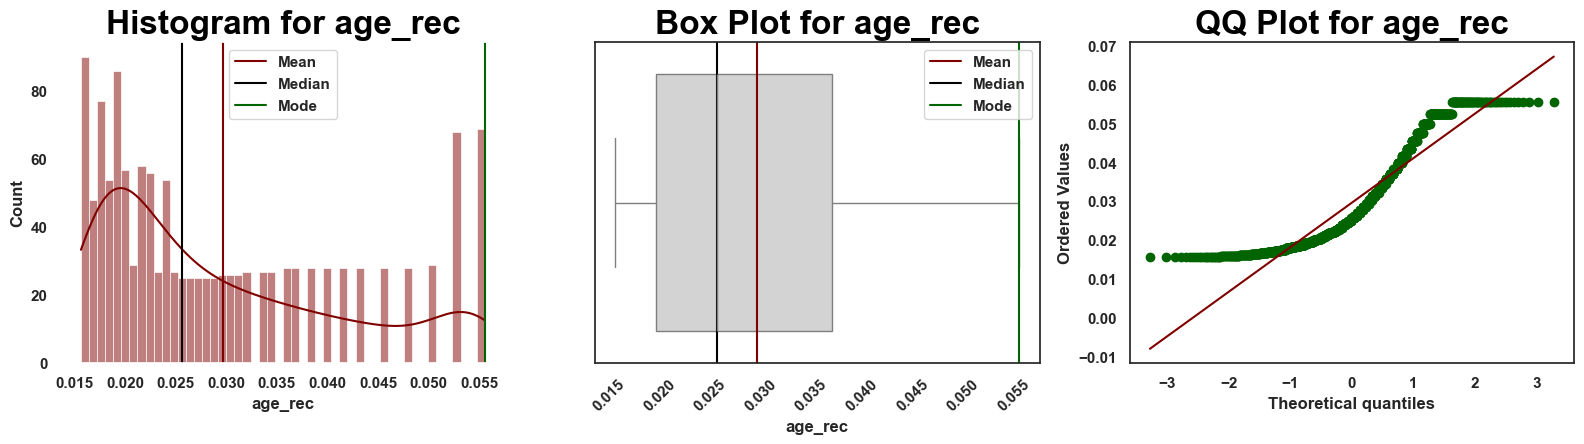



Skew for age_rec is 0.80

Kurtosis for age_rec is -0.61




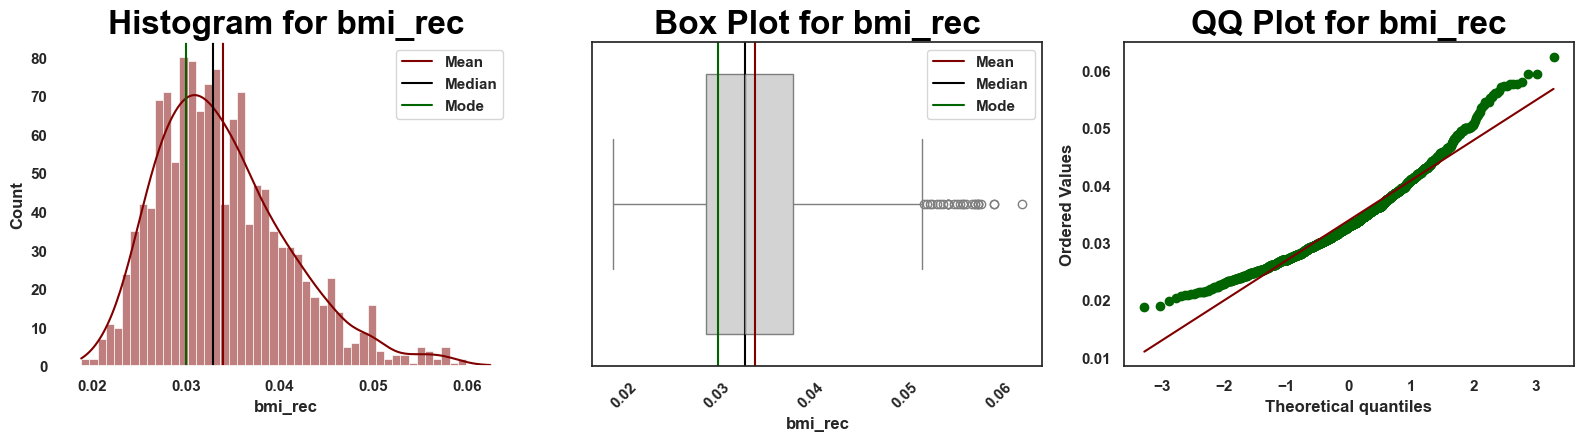



Skew for bmi_rec is 0.82

Kurtosis for bmi_rec is 0.72




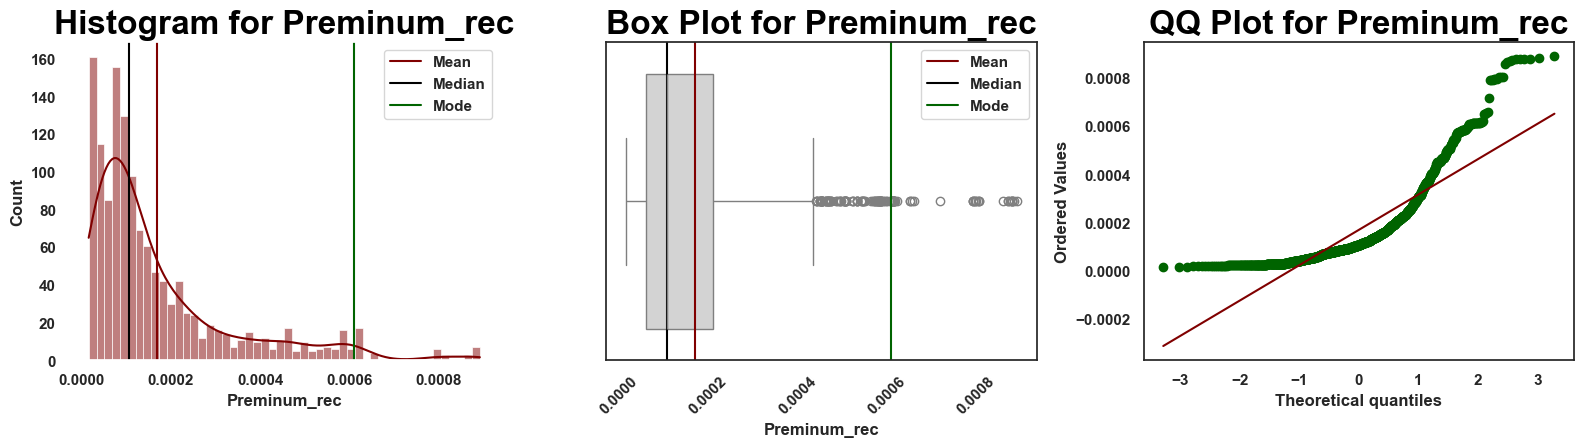



Skew for Preminum_rec is 1.88

Kurtosis for Preminum_rec is 3.45




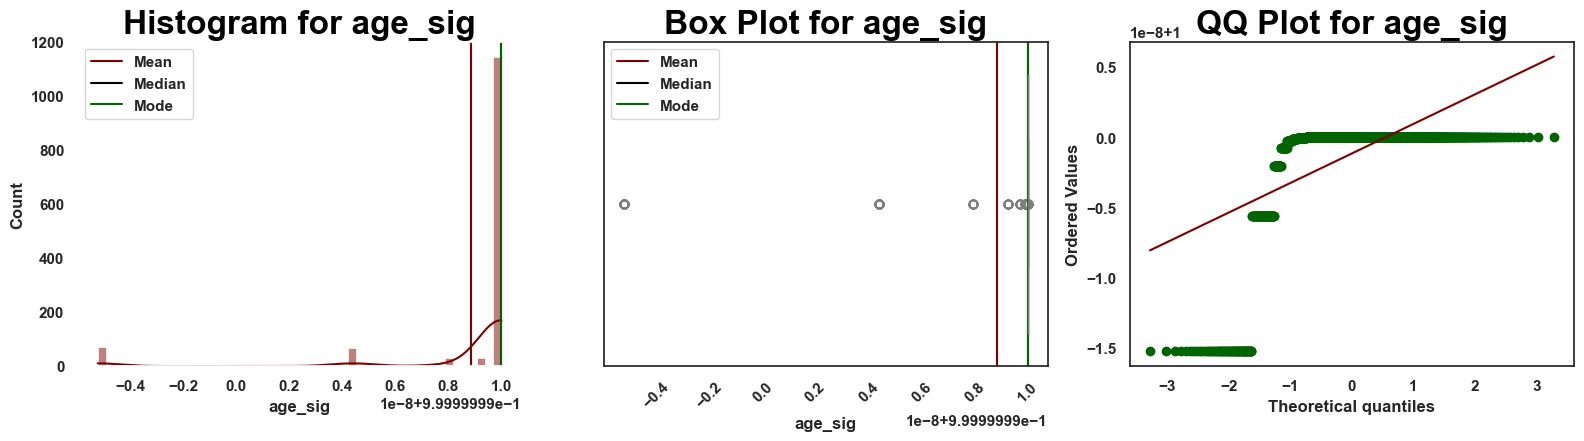



Skew for age_sig is 0.00

Kurtosis for age_sig is 0.00




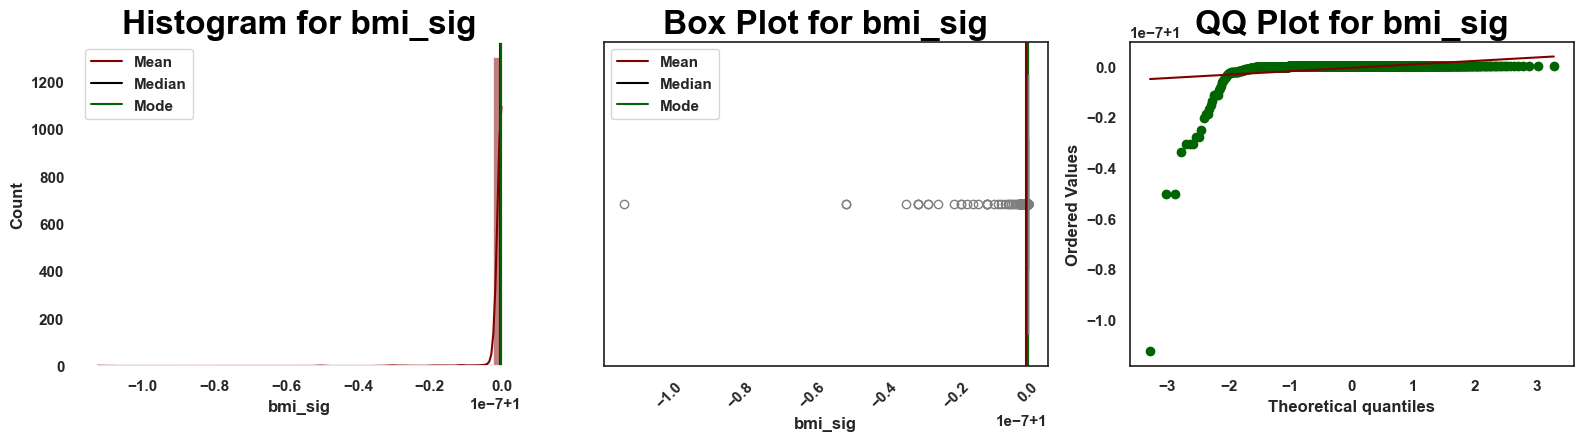



Skew for bmi_sig is 0.00

Kurtosis for bmi_sig is 0.00




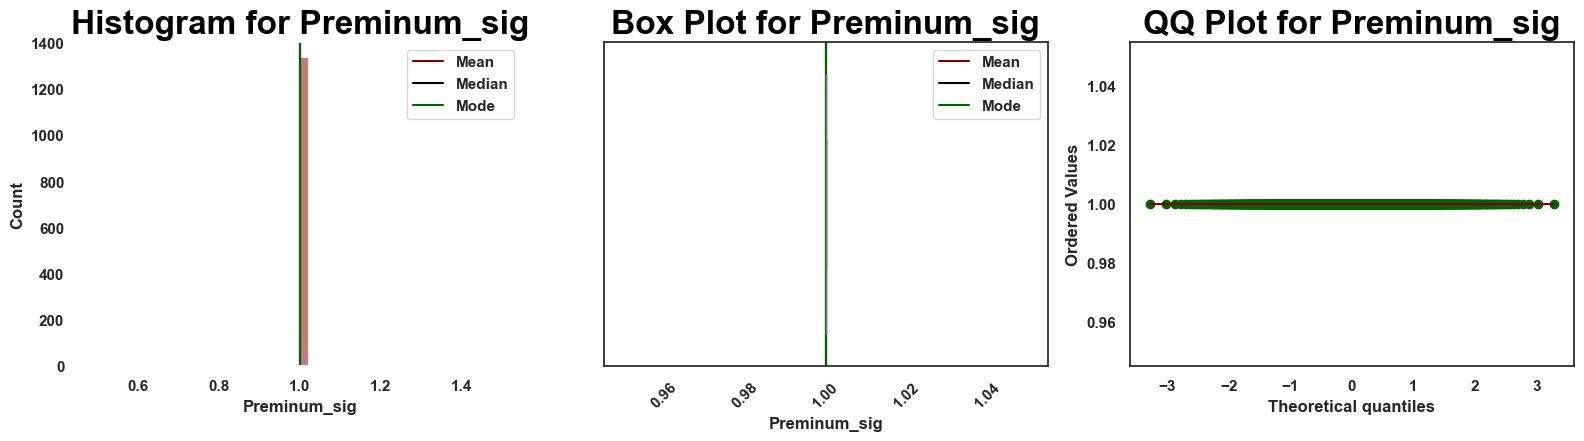



Skew for Preminum_sig is 0.00

Kurtosis for Preminum_sig is 0.00




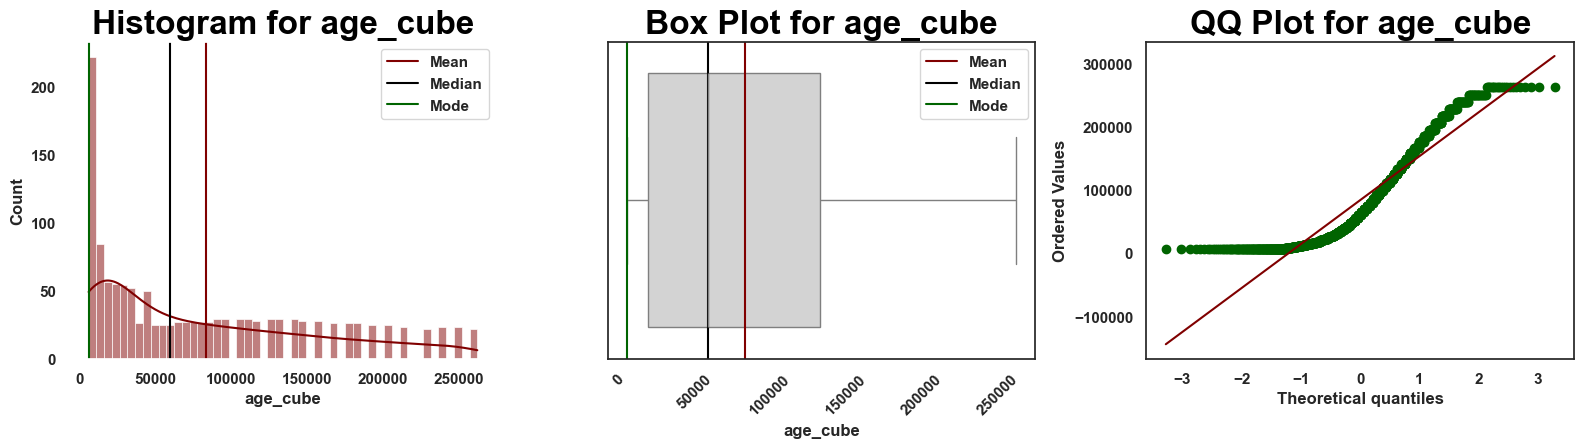



Skew for age_cube is 0.81

Kurtosis for age_cube is -0.50




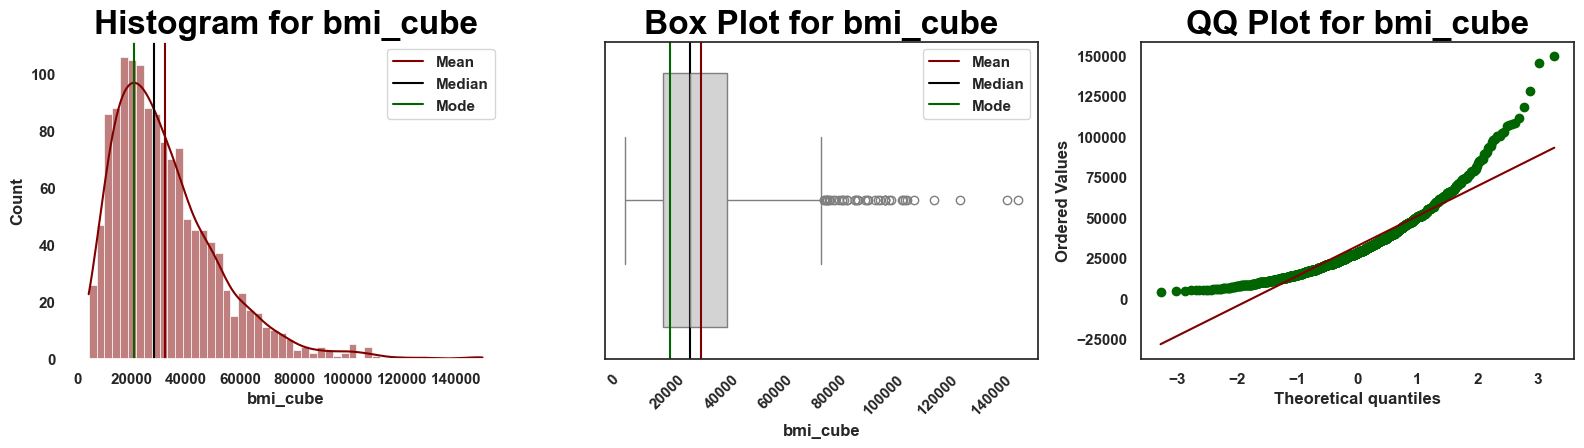



Skew for bmi_cube is 1.46

Kurtosis for bmi_cube is 3.40




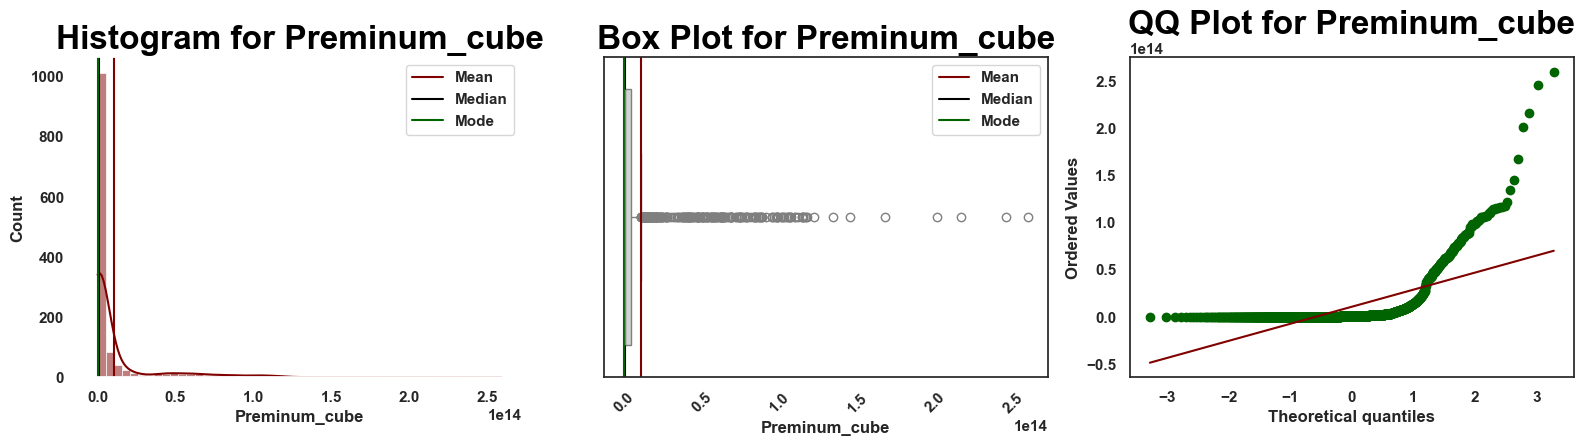



Skew for Preminum_cube is 3.80

Kurtosis for Preminum_cube is 19.24




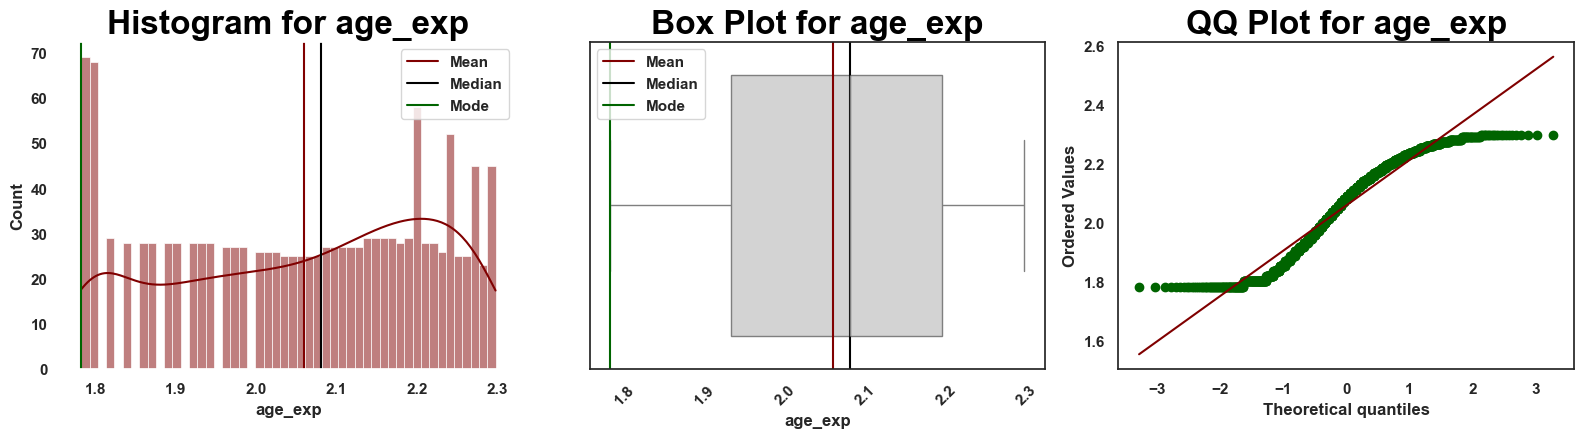



Skew for age_exp is -0.29

Kurtosis for age_exp is -1.17




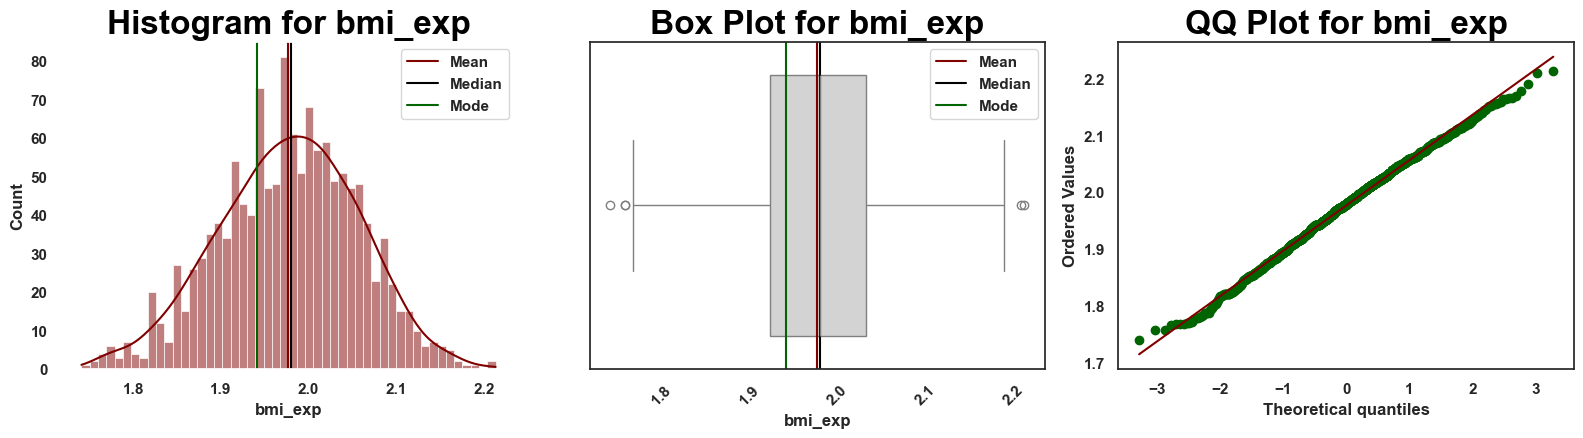



Skew for bmi_exp is -0.15

Kurtosis for bmi_exp is -0.20




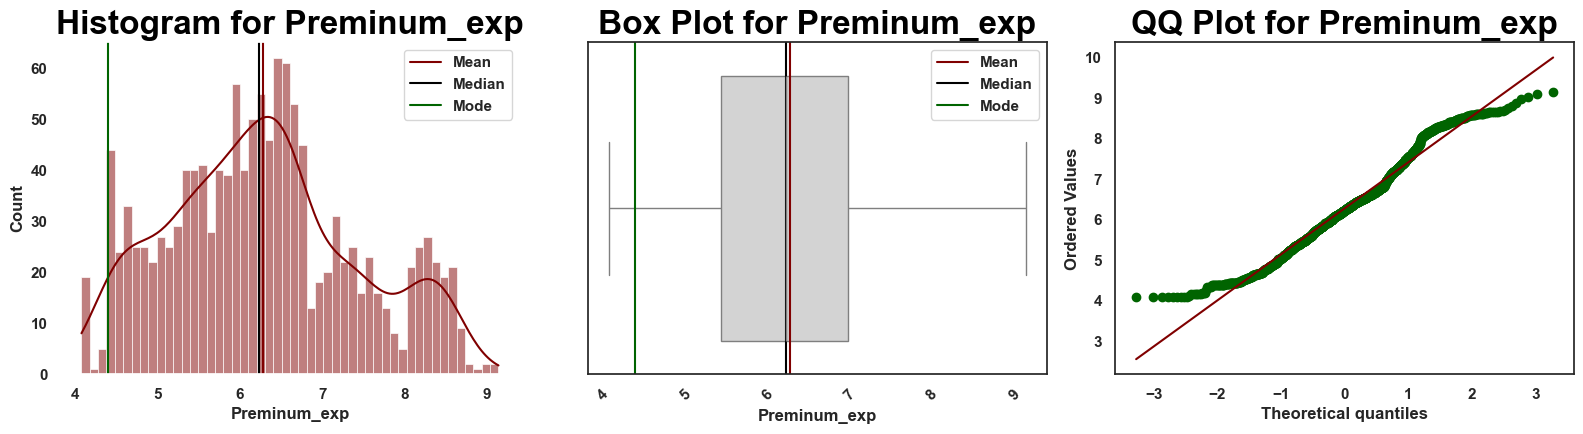



Skew for Preminum_exp is 0.28

Kurtosis for Preminum_exp is -0.59




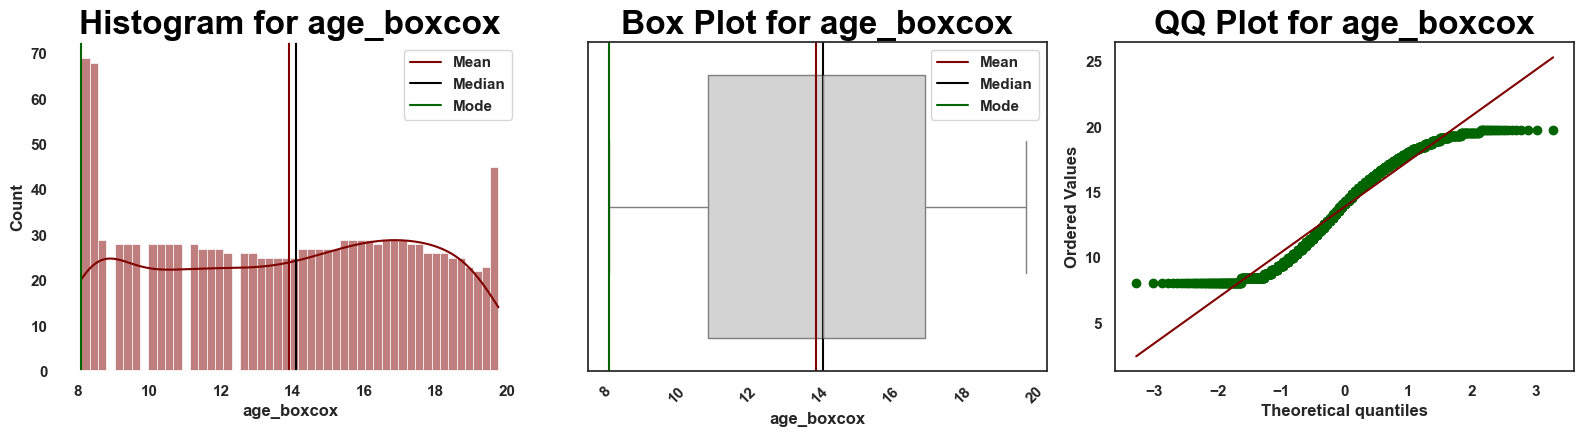



Skew for age_boxcox is -0.10

Kurtosis for age_boxcox is -1.24




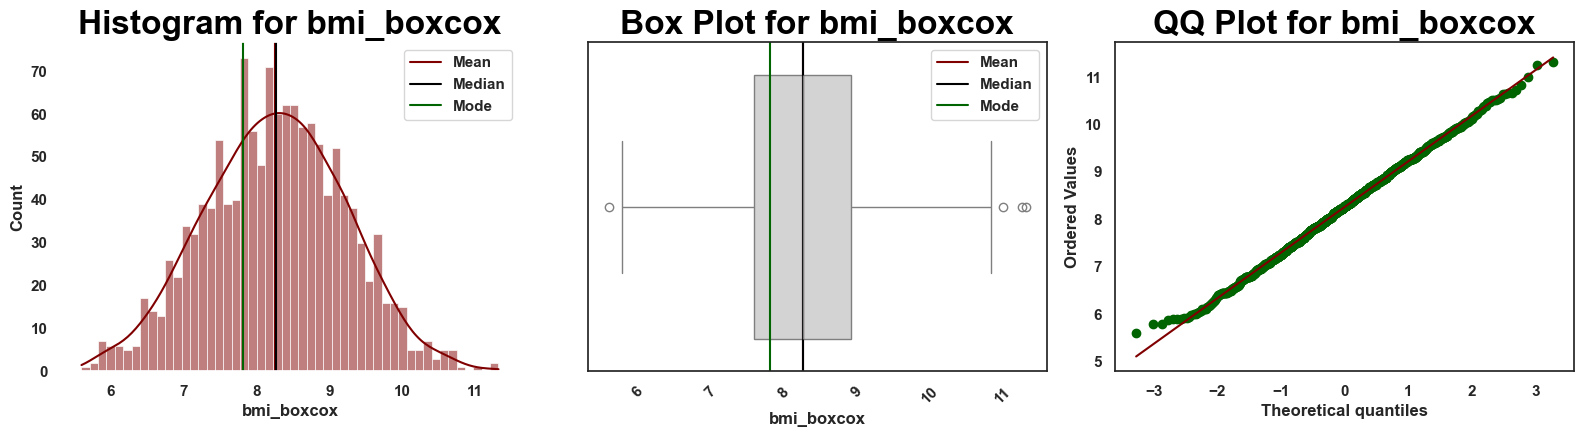



Skew for bmi_boxcox is -0.01

Kurtosis for bmi_boxcox is -0.21




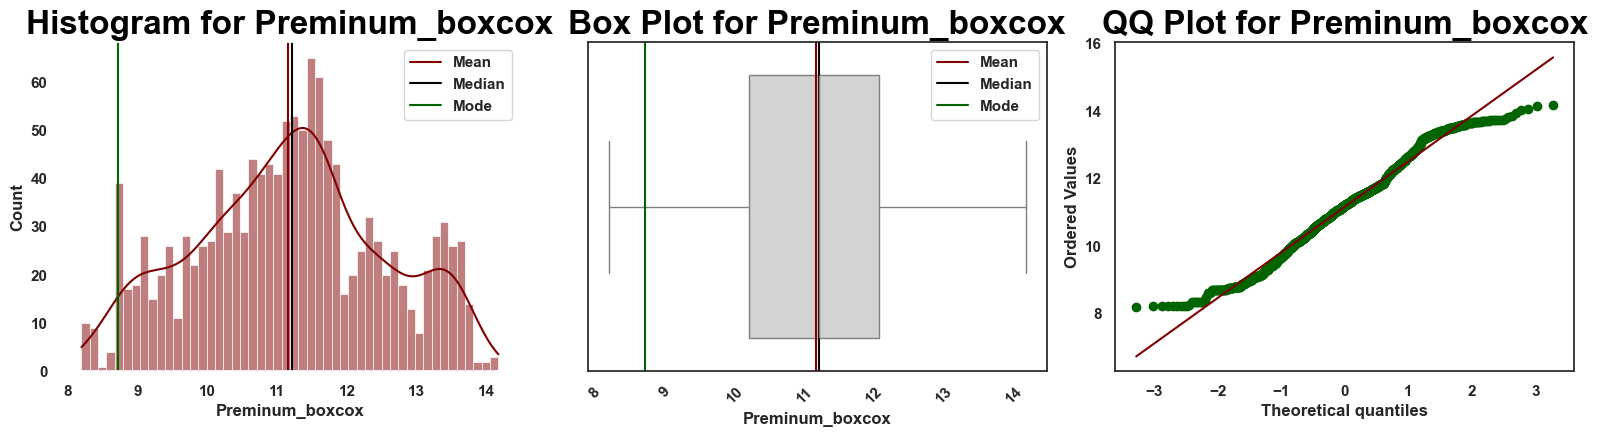



Skew for Preminum_boxcox is -0.01

Kurtosis for Preminum_boxcox is -0.65


Skewness:
 {'age_log': np.float64(-0.37323645636828134), 'bmi_log': np.float64(-0.2554889615538569), 'Preminum_log': np.float64(-0.08893381650125218), 'age_square': np.float64(-0.15595393702573024), 'bmi_square': np.float64(0.014670007653195666), 'Preminum_square': np.float64(0.7983994881340726), 'age_rec': np.float64(0.8030158591977173), 'bmi_rec': np.float64(0.818270456125389), 'Preminum_rec': np.float64(1.8760604095732638), 'age_sig': np.float64(0.0), 'bmi_sig': np.float64(0.0), 'Preminum_sig': np.float64(0.0), 'age_cube': np.float64(0.8076158271442545), 'bmi_cube': np.float64(1.4593372463823184), 'Preminum_cube': np.float64(3.80239916745702), 'age_exp': np.float64(-0.28602181274550204), 'bmi_exp': np.float64(-0.14699000412224117), 'Preminum_exp': np.float64(0.2801564510507891), 'age_boxcox': np.float64(-0.10347360574598136), 'bmi_boxcox': np.float64(-0.007214862174689082), 'Preminum_boxcox': np.float64(-0.

In [27]:
transformed_skewness = {}
transformed_kurtosis = {}
for i in normalized_df.columns:
    univar_num(normalized_df,i)
    skews=normalized_df[i].skew()
    kurt=normalized_df[i].kurtosis()
    transformed_skewness.update({i:skews})
    transformed_kurtosis.update({i:kurt})
    color = color_neutral
    if -0.5 <= skews <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skews <= 0.5 or -0.5 < skews < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
      
    print(f"\n\n{color}Skew for {i} is {skews:.2f}{color_neutral}")    
    print(f"\n{color}Kurtosis for {i} is {kurt:.2f}{color_neutral}\n\n")
print( 'Skewness:\n',transformed_skewness,'\n\n','Kurtois:\n',transformed_kurtosis)

In [30]:
transformed_features = ['bmi_boxcox','Preminum_boxcox']
original_features = ['bmi','Preminum']

In [31]:
df[transformed_features] = normalized_df[transformed_features]
df = df.drop(original_features,axis=1)

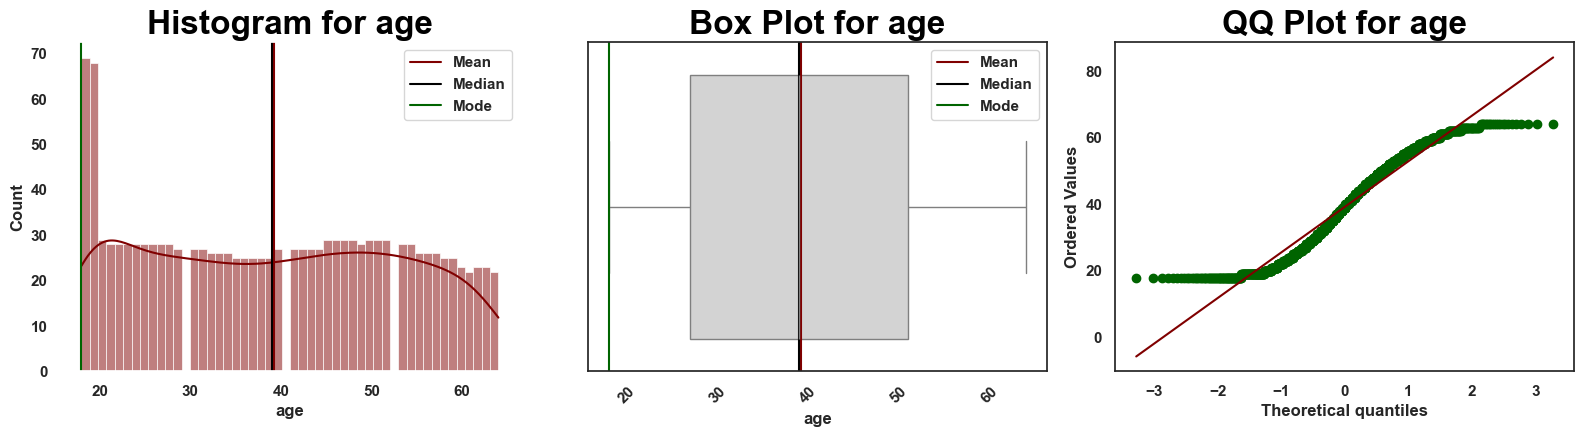



Skew for age is 0.0565
Kurtosis for age is -1.2442




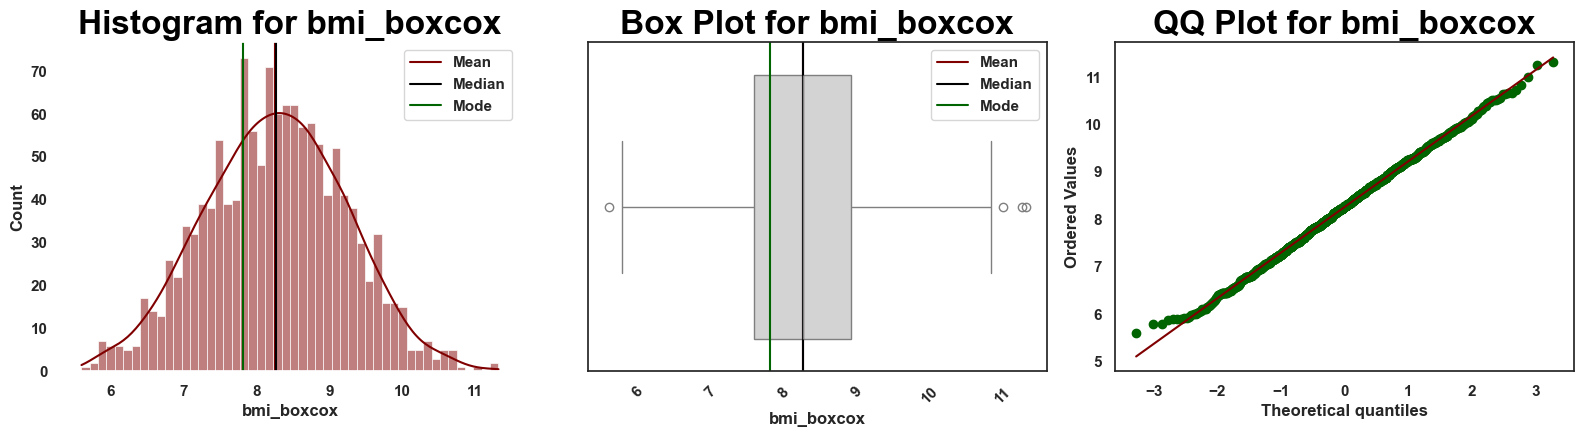



Skew for bmi_boxcox is -0.0072
Kurtosis for bmi_boxcox is -0.2144




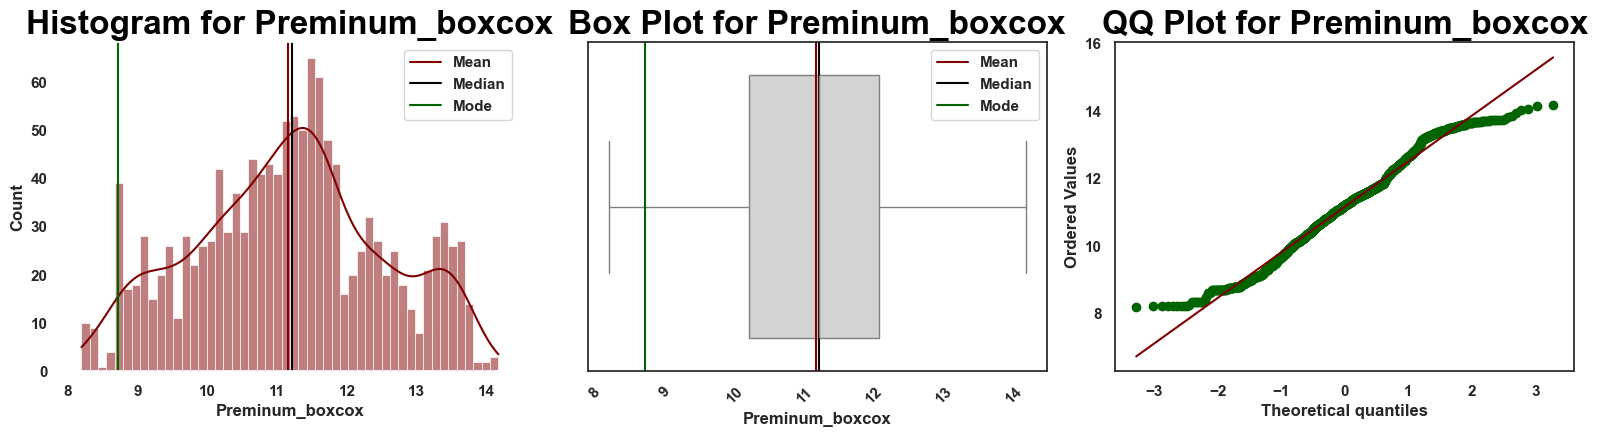



Skew for Preminum_boxcox is -0.0086
Kurtosis for Preminum_boxcox is -0.6482




In [33]:
continuous = ['age','bmi_boxcox','Preminum_boxcox',]

skewed_col = []

_ = list(map(process_column, continuous))

In [34]:
df

age  sex  children  smoker     region  bmi_boxcox  Preminum_boxcox
0      18    1         1       0  southeast      8.7911           8.7880
1      18    1         0       0  southeast      8.8357           8.2181
2      18    0         0       0  northeast      7.5972           9.1234
3      18    0         2       0  northeast      9.4947           9.7338
4      18    0         0       0  northeast      9.0556           9.1316
...   ...  ...       ...     ...        ...         ...              ...
1332   64    0         2       0  northeast      8.4881          12.0161
1333   64    0         0       1  northwest      7.6990          12.9411
1334   64    1         0       0  northeast      7.6143          11.8495
1335   64    1         2       1  southeast      9.2564          13.7677
1336   64    1         0       1  southeast      7.1590          12.8081

[1337 rows x 7 columns]

In [38]:
region = pd.get_dummies(df['region'],prefix='region_',dtype='int8')
df1 = pd.concat([df,region],axis=1)
df1 = df1.drop('region',axis=1)
df1.sample(3)

age  sex  children  smoker  bmi_boxcox  Preminum_boxcox  \
336    27    1         3       0      6.2210          10.2380   
889    47    1         1       1      9.1278          13.5124   
1058   53    1         1       0      6.7141          11.3134   

      region__northeast  region__northwest  region__southeast  \
336                   1                  0                  0   
889                   0                  0                  1   
1058                  0                  0                  0   

      region__southwest  
336                   0  
889                   0  
1058                  1

## <span style="color:Aqua;">Preparing the data afor modeling:</span>

In [50]:
df.drop_duplicates()
x = df1.drop('Preminum_boxcox',axis=1)
y = df1['Preminum_boxcox']

In [51]:
x.describe()

age       sex  children    smoker  bmi_boxcox  region__northeast  \
count 1337.0000 1337.0000 1337.0000 1337.0000   1337.0000          1337.0000   
mean    39.1907    0.5056    1.0957    0.2042      8.2599             0.2423   
std     14.0426    0.5002    1.2056    0.4033      0.9611             0.4287   
min     18.0000    0.0000    0.0000    0.0000      5.6024             0.0000   
25%     27.0000    0.0000    0.0000    0.0000      7.5972             0.0000   
50%     39.0000    1.0000    1.0000    0.0000      8.2698             0.0000   
75%     51.0000    1.0000    2.0000    0.0000      8.9243             0.0000   
max     64.0000    1.0000    5.0000    1.0000     11.3200             1.0000   

       region__northwest  region__southeast  region__southwest  
count          1337.0000          1337.0000          1337.0000  
mean              0.2423             0.2723             0.2431  
std               0.4287             0.4453             0.4291  
min               0.0000             0.0000             0.0000  
25%               0.0000             0.0000             0.0000  
50%               0.0000             0.0000             0.0000  
75%               0.0000             1.0000             0.0000  
max               1.0000             1.0000             1.0000

In [52]:
y.describe()

count   1337.0000
mean      11.1636
std        1.3589
min        8.2000
25%       10.2110
50%       11.2083
75%       12.0642
max       14.1708
Name: Preminum_boxcox, dtype: float64

## <span style="color:Aqua;">Splitting data for train_test and resampling imbalanced data classess:</span>

In [53]:
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size=.3,random_state=42)

In [54]:
print(x_train.shape,'----', y_train.shape)
print(x_test.shape,'----', y_test.shape)

(935, 9) ---- (935,)
(402, 9) ---- (402,)


In [55]:
x_test.sample(2)

age  sex  children  smoker  bmi_boxcox  region__northeast  \
254   24    1         0       0      9.0990                  0   
792   44    0         1       1      6.4815                  1   

     region__northwest  region__southeast  region__southwest  
254                  0                  1                  0  
792                  0                  0                  0

In [56]:
y_test.sample(2)

746   10.7870
661   10.5808
Name: Preminum_boxcox, dtype: float64

## <span style="color:Aqua;">Normalizing / Scaling the data:</span>

In [58]:
continuous = ['age','bmi_boxcox']


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[continuous])
x_test_scaled = scaler.transform(x_test[continuous])
y_train, y_test = y_train.values.ravel(), y_test.values.ravel()

In [59]:
x_train_scaled_continuous = pd.DataFrame(x_train_scaled, columns=continuous )
x_test_scaled_continuous = pd.DataFrame(x_test_scaled, columns=continuous)

In [60]:
x_train_drop = x_train.drop(columns = continuous ,axis=1)
x_test_drop  = x_test.drop(columns = continuous , axis=1)

In [61]:
x_train_scaled_df = pd.concat([x_train_drop.reset_index(drop=True), x_train_scaled_continuous.reset_index(drop=True)], axis=1)
x_test_scaled_df = pd.concat([x_test_drop.reset_index(drop=True),x_test_scaled_continuous.reset_index(drop=True)], axis=1)

In [62]:
print(x_train.shape)
x_train.sample(1)

(935, 9)


age  sex  children  smoker  bmi_boxcox  region__northeast  \
1057   53    1         3       0      9.1994                  0   

      region__northwest  region__southeast  region__southwest  
1057                  0                  0                  1

In [63]:
print(x_train_scaled_df.shape)
x_train_scaled_df.sample(1)

(935, 9)


sex  children  smoker  region__northeast  region__northwest  \
615    1         2       1                  0                  0   

     region__southeast  region__southwest     age  bmi_boxcox  
615                  0                  1 -0.9346      0.3999

In [64]:
print(x_test.shape)
x_test.sample(1)

(402, 9)


age  sex  children  smoker  bmi_boxcox  region__northeast  \
1022   52    0         5       0     10.5594                  0   

      region__northwest  region__southeast  region__southwest  
1022                  0                  1                  0

In [65]:
print(x_test_scaled_df.shape)
x_test_scaled_df.sample(1)

(402, 9)


sex  children  smoker  region__northeast  region__northwest  \
303    0         0       0                  1                  0   

     region__southeast  region__southwest     age  bmi_boxcox  
303                  0                  0 -1.3608      0.0310

## <span style="color:Aqua;">Training all the model:</span>

#### <span style="color:Khaki;">Defing the function to train and evaluate the model:</span>

In [66]:
def evaluate_model(model, x_train, y_train, x_test, y_test, color_positive='\033[92m', reset_color='\033[0m'):
    print(f"\n{model.__class__.__name__}\n")

    start_time = time.time()
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    y_preds_train = model.predict(x_train)
    training_time = time.time() - start_time

    print(f"{color_positive}Training Time: {training_time:.2f} seconds\n")

    if isinstance(model, LinearRegression) or (isinstance(model, MultiOutputRegressor) and isinstance(model.estimator, LinearRegression)):
        if isinstance(model, MultiOutputRegressor):
            coefs = [est.coef_ for est in model.estimators_]
        else:
            coefs = model.coef_
        print(f"{color_positive}Coefficients - {reset_color} {coefs}")

    metrics = {
        "Mean Squared Error": mean_squared_error,
        "R2 Score": r2_score,
        "Mean Absolute Error": mean_absolute_error,
        "Median Absolute Error": median_absolute_error,
        "Explained Variance Score": explained_variance_score,
        "Max Error": max_error
    }

    def safe_metric(metric_func, y_true, y_pred):
        if isinstance(y_true, (pd.DataFrame, pd.Series)):
            y_true = y_true.values
        if isinstance(y_pred, (pd.DataFrame, pd.Series)):
            y_pred = y_pred.values
        
        try:
            return metric_func(y_true, y_pred, multioutput='uniform_average')
        except TypeError:
            if y_true.ndim > 1 and y_true.shape[1] > 1:
                return np.mean([metric_func(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])
            else:
                return metric_func(y_true, y_pred)

    for metric_name, metric_func in metrics.items():
        test_score = safe_metric(metric_func, y_test, y_preds)
        train_score = safe_metric(metric_func, y_train, y_preds_train)
        
        print(f"{color_positive}Test {metric_name} {reset_color} -- {test_score:.4f}")
        print(f"{color_positive}Train {metric_name} {reset_color} -- {train_score:.4f}\n")

    # Handle Root Mean Squared Error separately
    test_rmse = np.sqrt(safe_metric(mean_squared_error, y_test, y_preds))
    train_rmse = np.sqrt(safe_metric(mean_squared_error, y_train, y_preds_train))
    print(f"{color_positive}Test Root Mean Squared Error {reset_color} -- {test_rmse:.4f}")
    print(f"{color_positive}Train Root Mean Squared Error {reset_color} -- {train_rmse:.4f}\n")

    print('-'*50)

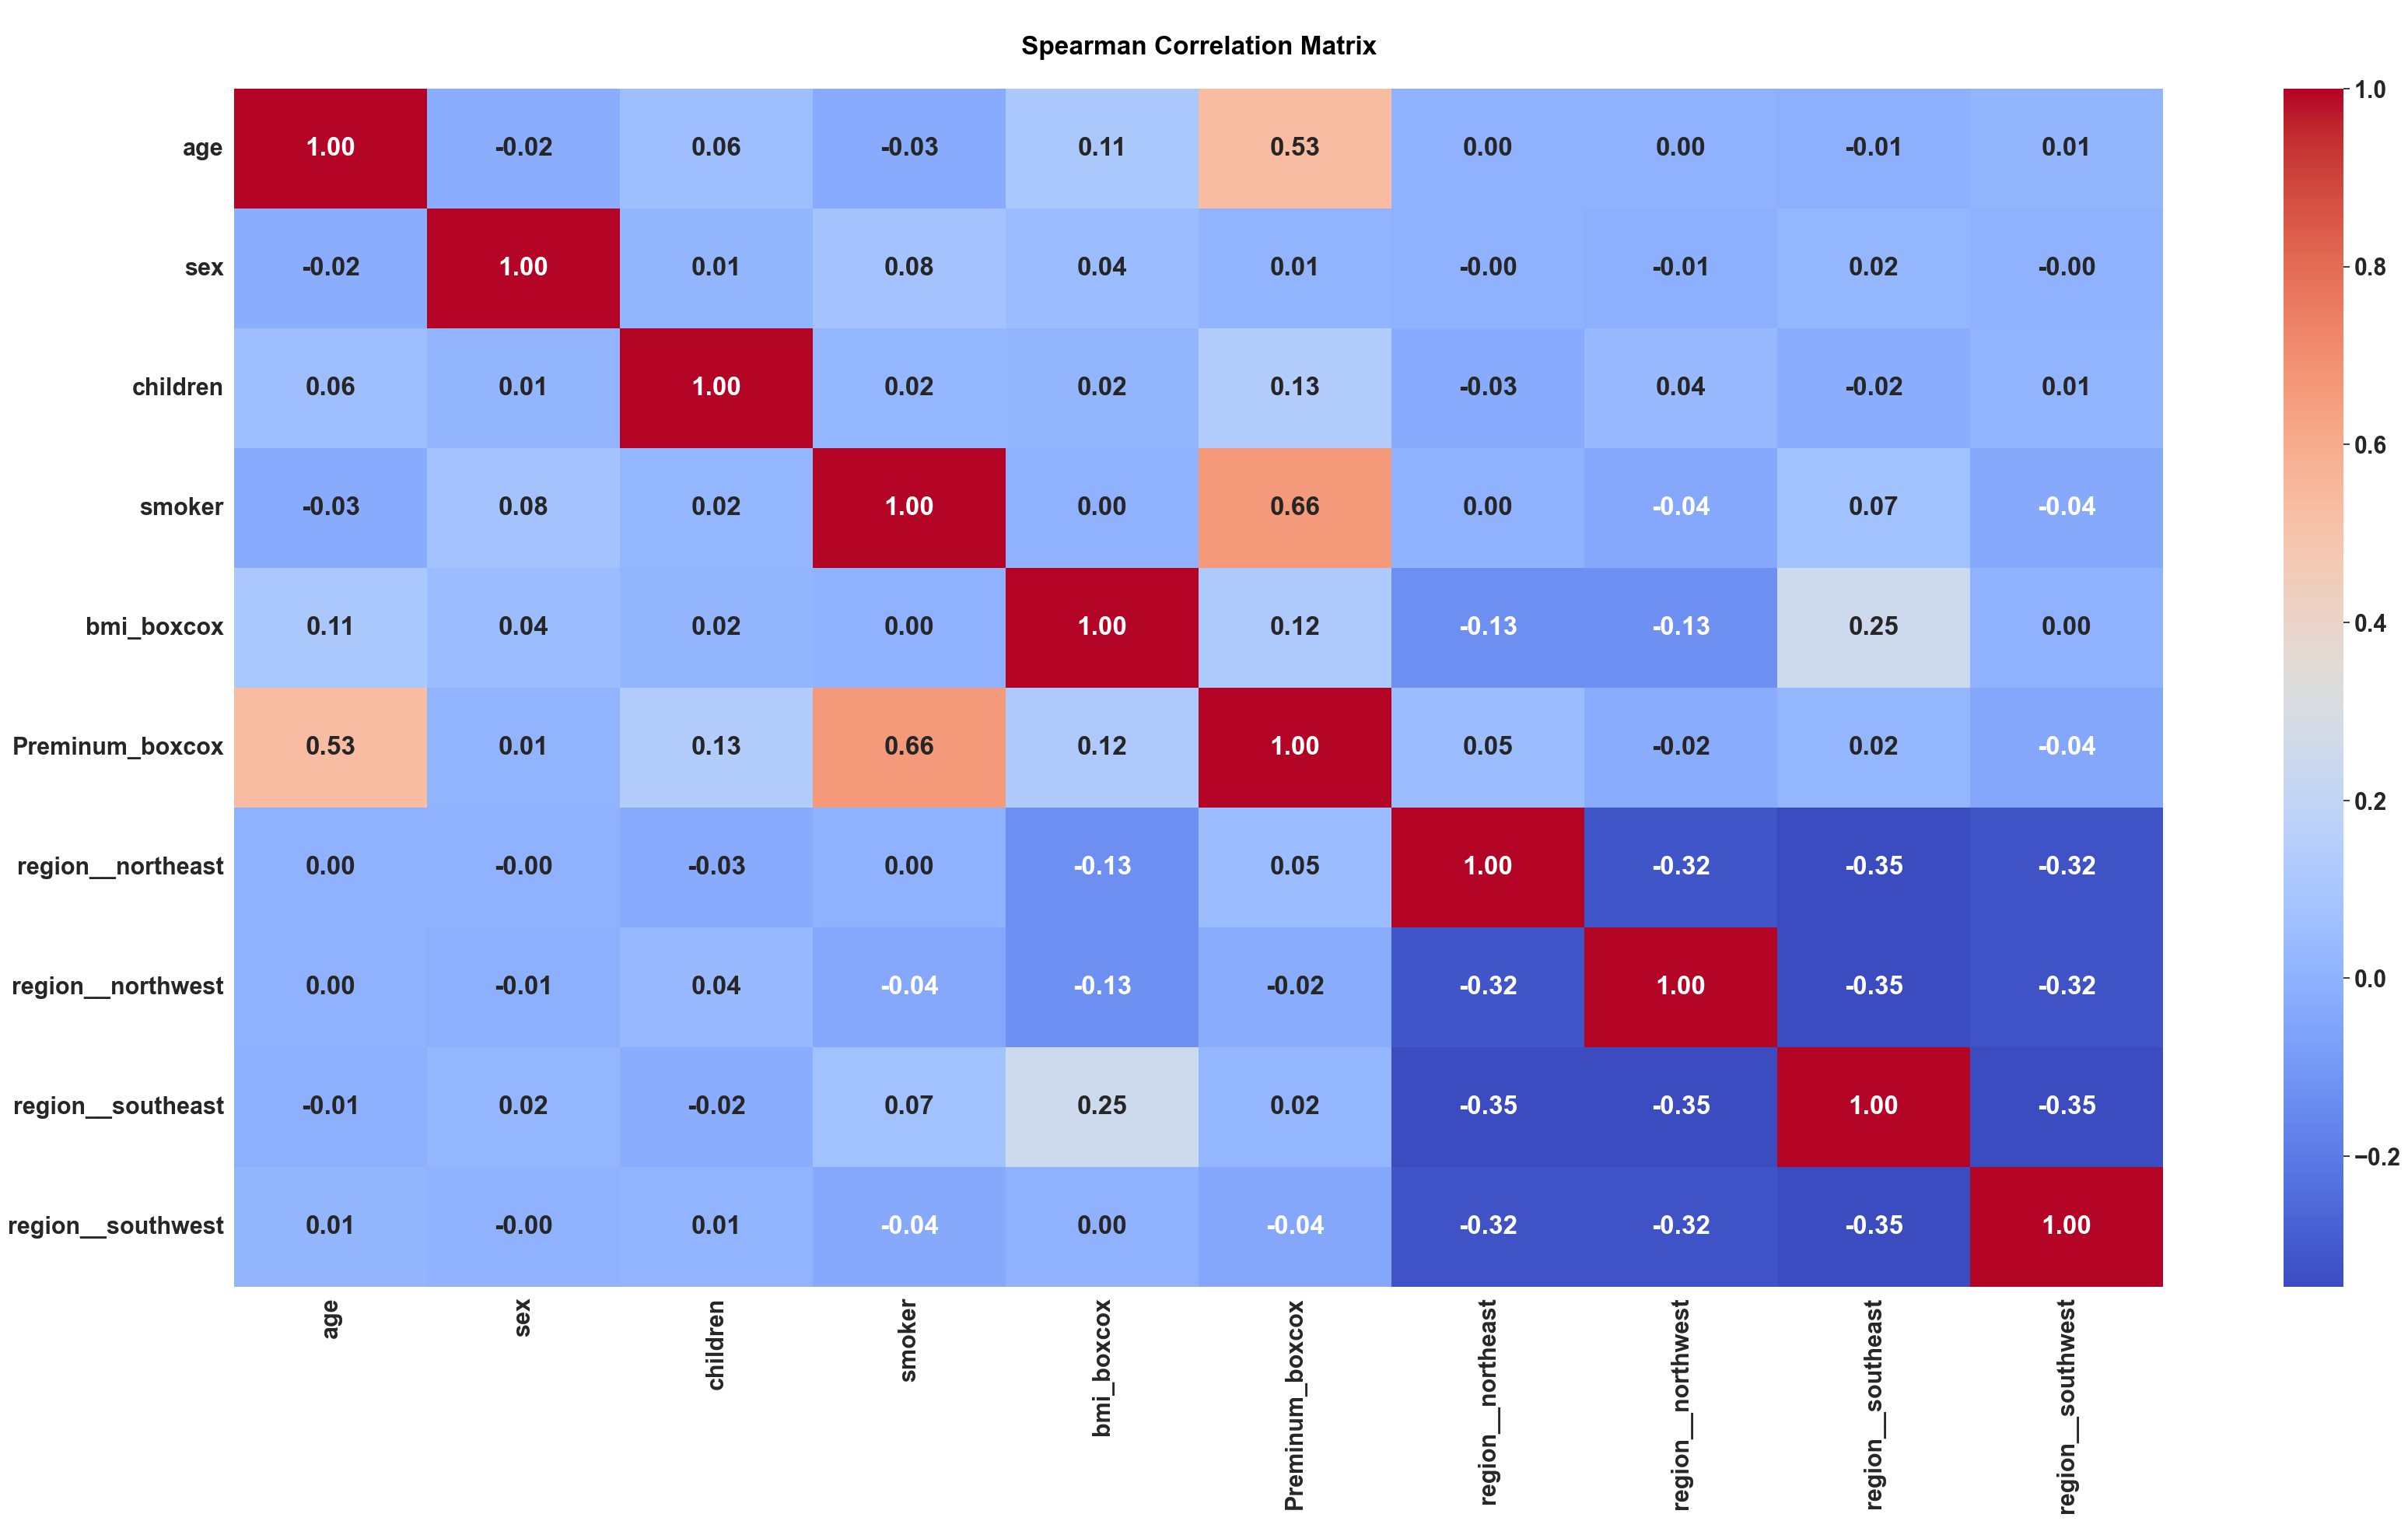

In [69]:
plt.figure(figsize=(40,20))
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=2, color_codes=True, rc=None)
# continuous.extend(['policy_annual_premium_boxcox','insured_sex','property_damage','police_report_available','fraud_reported'])
cor_col = df1
correlation_matrix = cor_col.corr(method='spearman')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('\nSpearman Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()

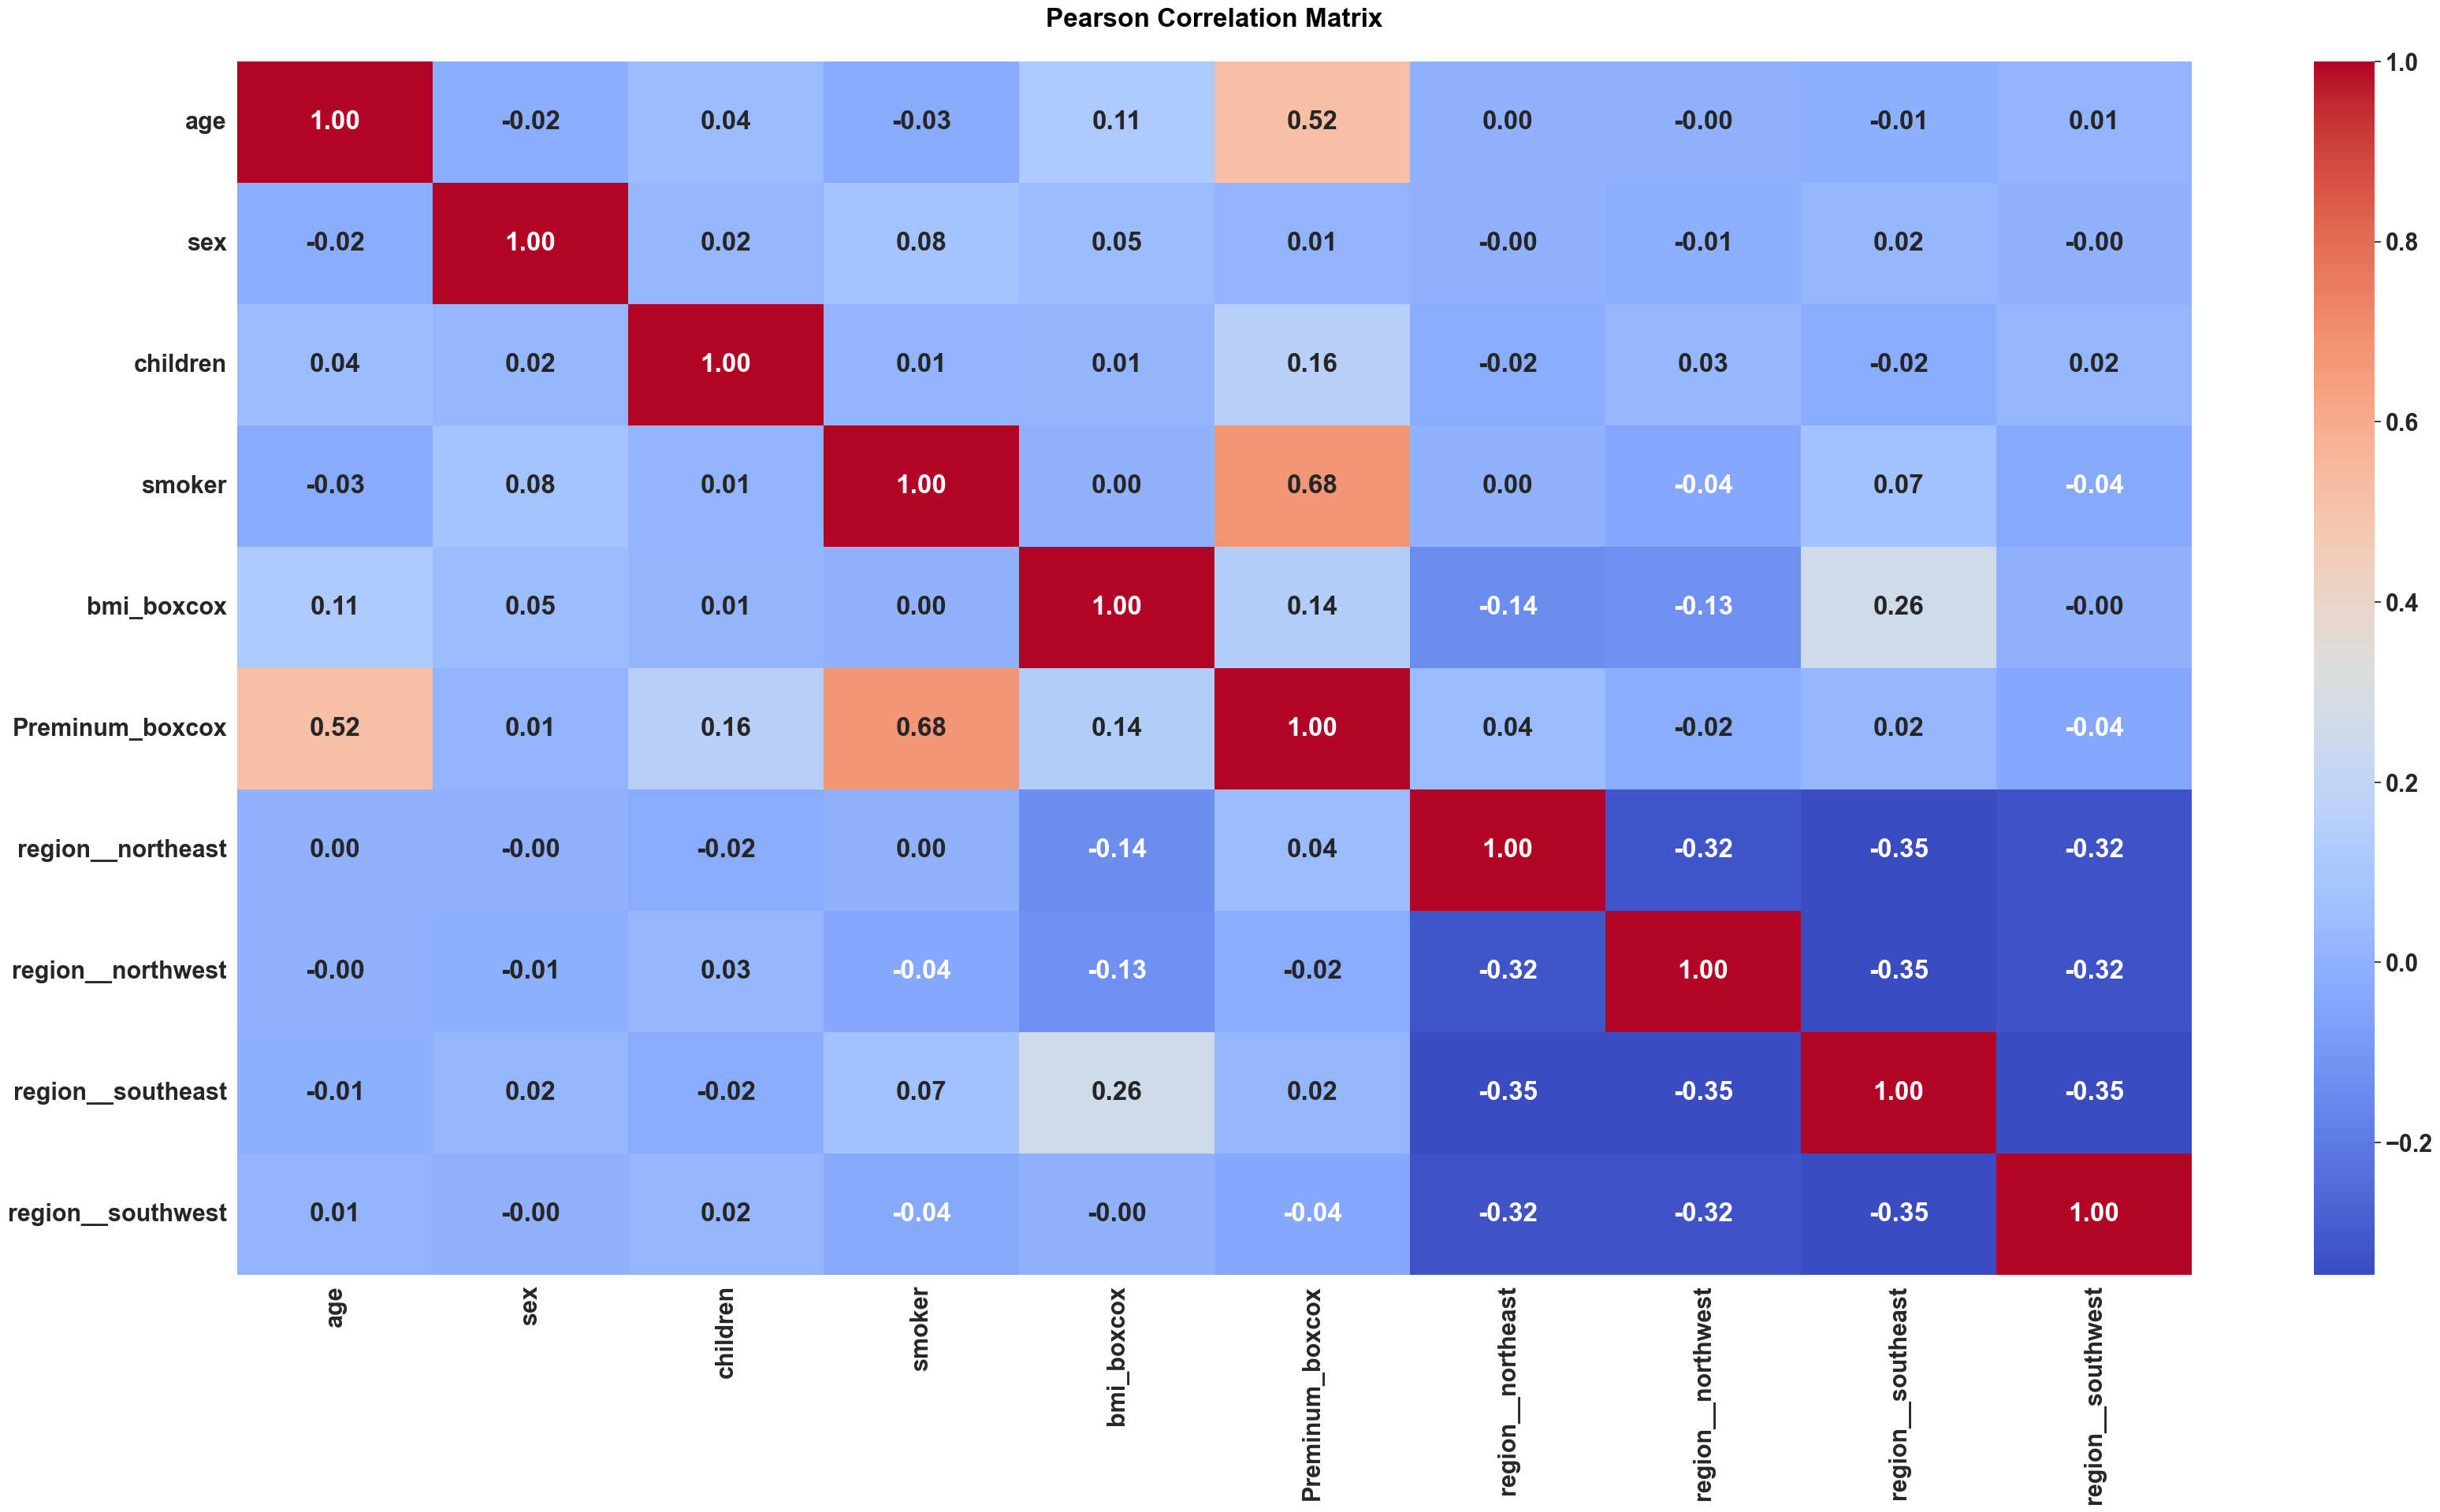

In [70]:
plt.figure(figsize=(40,20))
correlation_matrix = cor_col.corr(method='pearson')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Pearson Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()

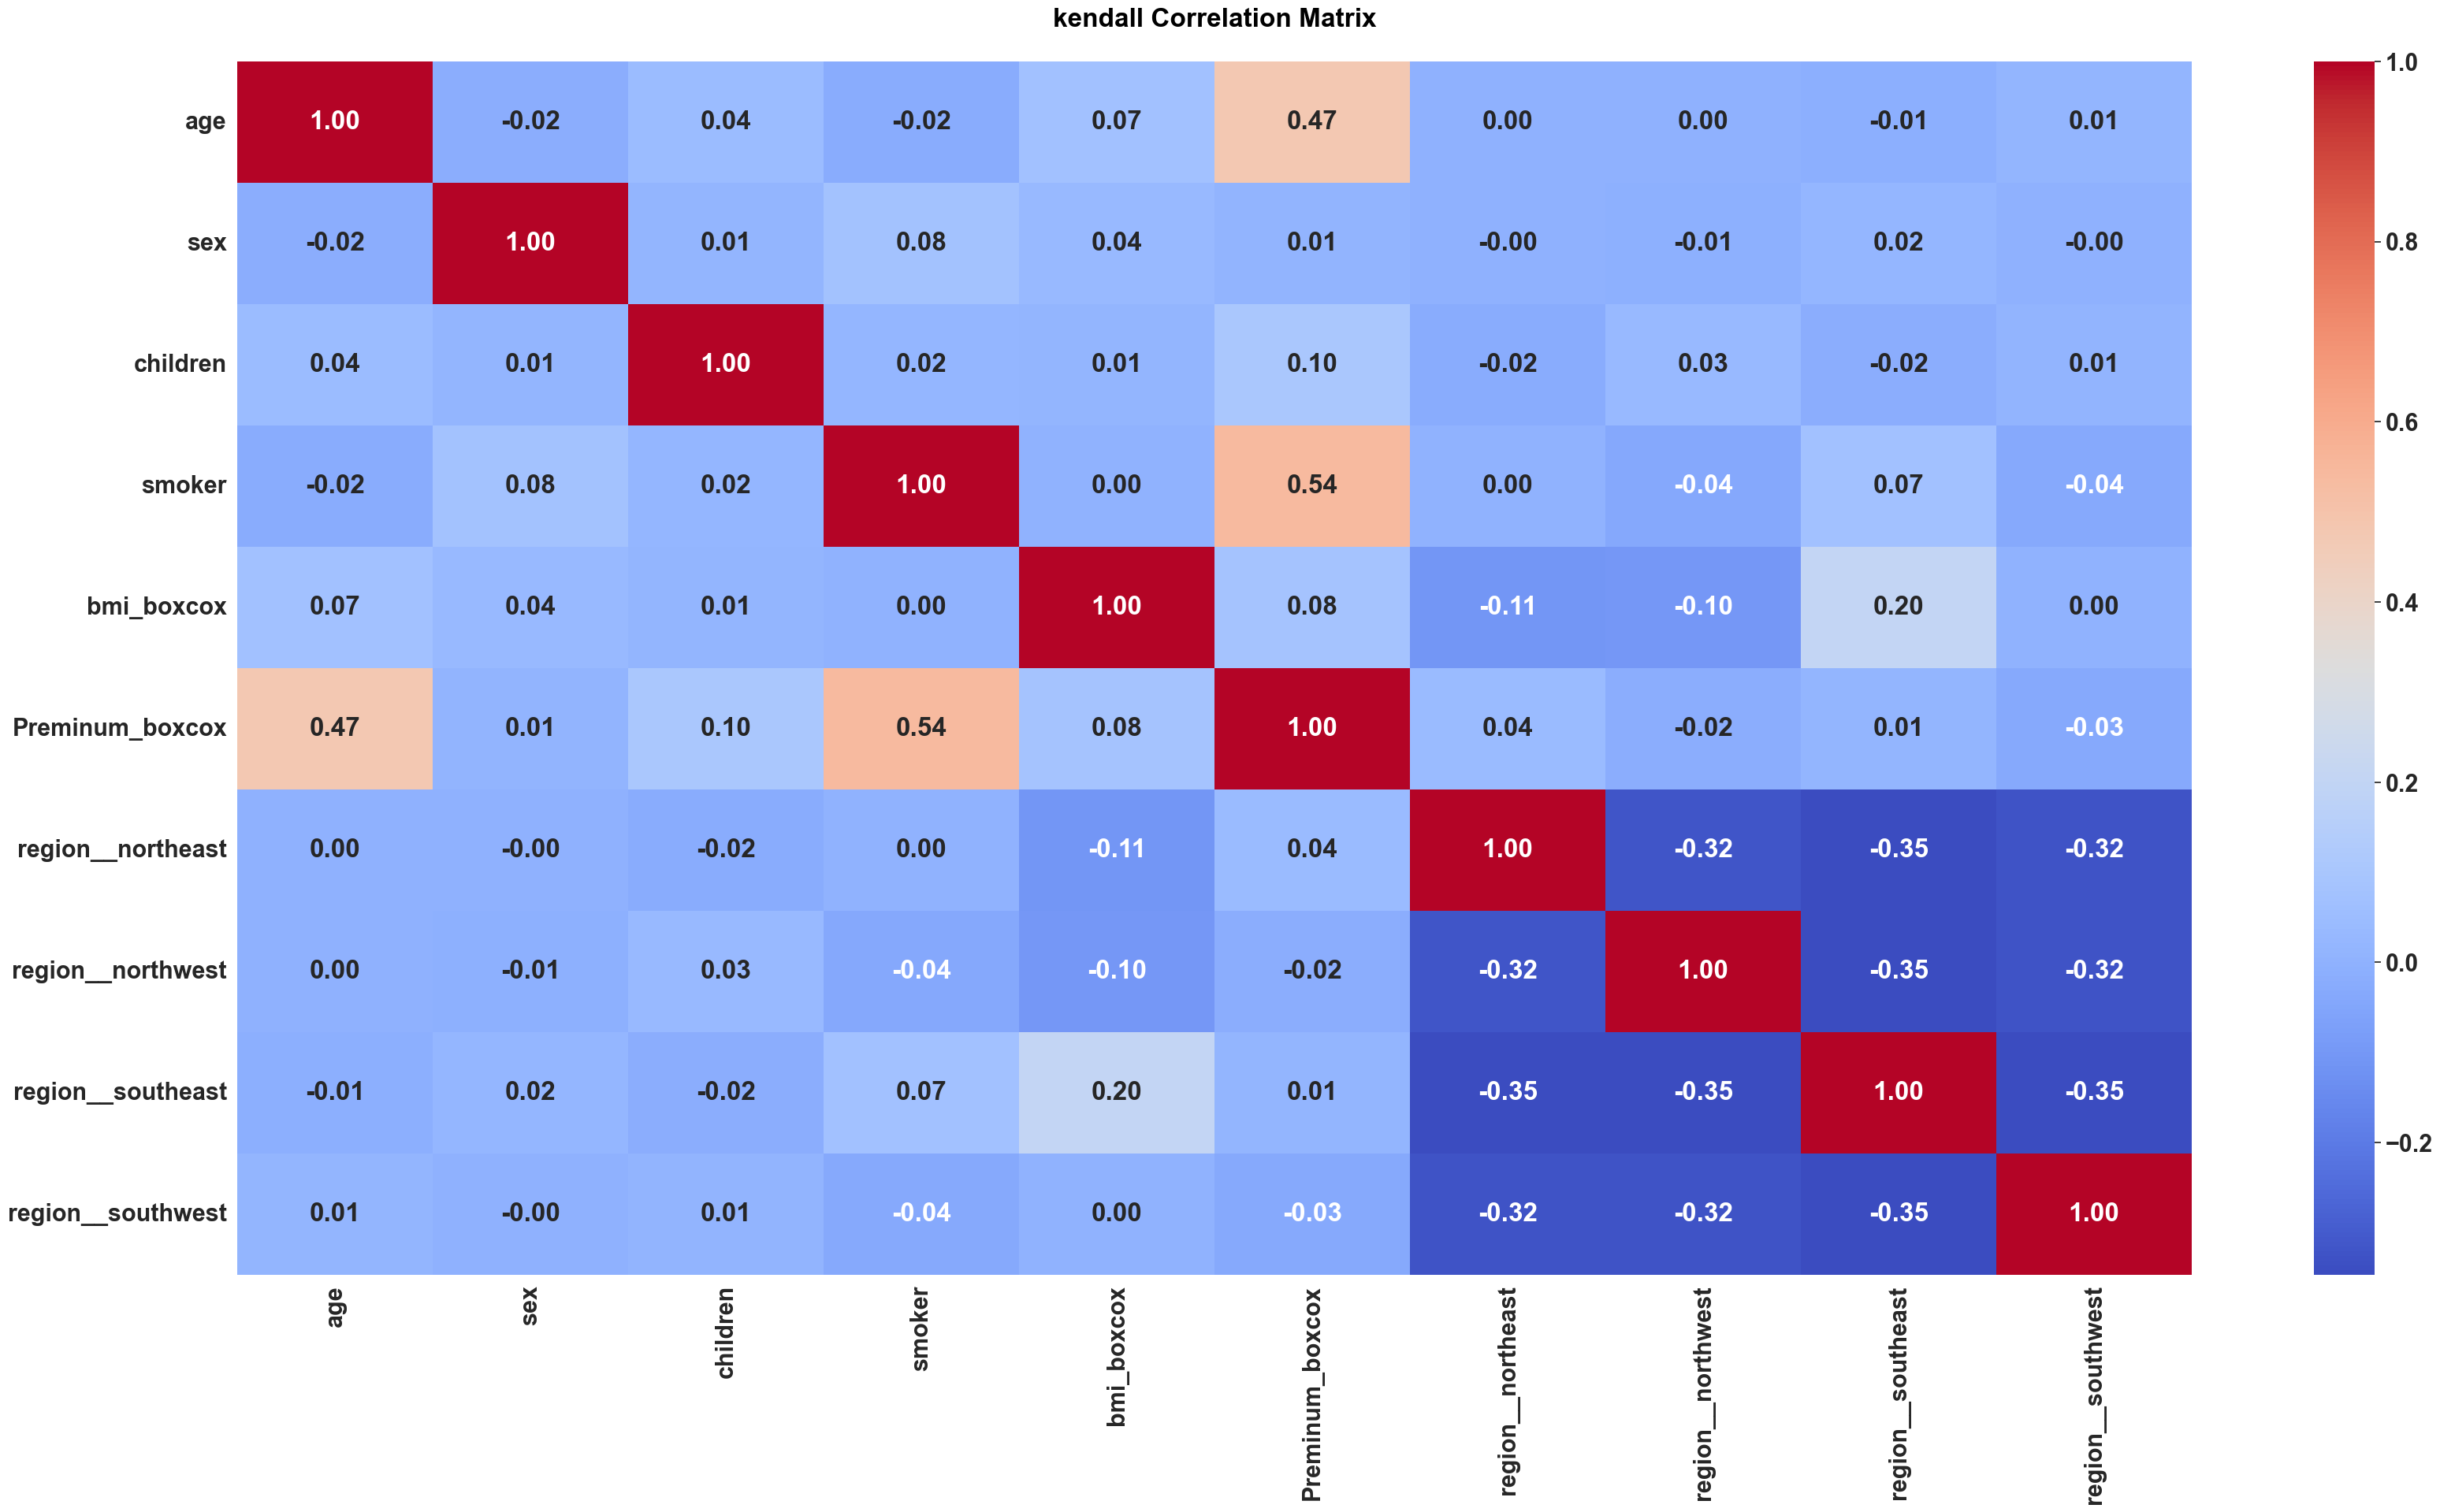

In [71]:
plt.figure(figsize=(40,20))
correlation_matrix = cor_col.corr(method='kendall')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('kendall Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()

In [73]:
df1.sample(1)

age  sex  children  smoker  bmi_boxcox  Preminum_boxcox  \
1288   62    0         0       0      8.6257          11.7907   

      region__northeast  region__northwest  region__southeast  \
1288                  0                  1                  0   

      region__southwest  
1288                  0

In [74]:
Linear_regressor = LinearRegression()
evaluate_model(Linear_regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


LinearRegression

Training Time: 0.03 seconds

Coefficients -  [-1.58260674e-01  1.46068744e-01  2.37394251e+00 -2.75316759e+12
 -2.75316759e+12 -2.75316759e+12 -2.75316759e+12  7.12922397e-01
  1.36936352e-01]
Test Mean Squared Error  -- 0.4055
Train Mean Squared Error  -- 0.4303

Test R2 Score  -- 0.7698
Train R2 Score  -- 0.7712

Test Mean Absolute Error  -- 0.4030
Train Mean Absolute Error  -- 0.4163

Test Median Absolute Error  -- 0.2243
Train Median Absolute Error  -- 0.2097

Test Explained Variance Score  -- 0.7705
Train Explained Variance Score  -- 0.7712

Test Max Error  -- 3.2192
Train Max Error  -- 3.1284

Test Root Mean Squared Error  -- 0.6368
Train Root Mean Squared Error  -- 0.6560

--------------------------------------------------


In [75]:
Ridge_regressor = Ridge(random_state=42)
evaluate_model(Ridge_regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


Ridge

Training Time: 0.02 seconds

Test Mean Squared Error  -- 0.4047
Train Mean Squared Error  -- 0.4304

Test R2 Score  -- 0.7703
Train R2 Score  -- 0.7712

Test Mean Absolute Error  -- 0.4037
Train Mean Absolute Error  -- 0.4172

Test Median Absolute Error  -- 0.2224
Train Median Absolute Error  -- 0.2074

Test Explained Variance Score  -- 0.7710
Train Explained Variance Score  -- 0.7712

Test Max Error  -- 3.2097
Train Max Error  -- 3.1220

Test Root Mean Squared Error  -- 0.6362
Train Root Mean Squared Error  -- 0.6560

--------------------------------------------------


In [76]:
Lasso_regressor = Lasso(random_state=42)
evaluate_model(Lasso_regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


Lasso

Training Time: 0.02 seconds

Test Mean Squared Error  -- 1.7618
Train Mean Squared Error  -- 1.8810

Test R2 Score  -- -0.0001
Train R2 Score  -- 0.0000

Test Mean Absolute Error  -- 1.0862
Train Mean Absolute Error  -- 1.1004

Test Median Absolute Error  -- 0.9601
Train Median Absolute Error  -- 0.9261

Test Explained Variance Score  -- 0.0000
Train Explained Variance Score  -- 0.0000

Test Max Error  -- 2.9436
Train Max Error  -- 3.0039

Test Root Mean Squared Error  -- 1.3273
Train Root Mean Squared Error  -- 1.3715

--------------------------------------------------


In [77]:
DT_Regressor = DecisionTreeRegressor(random_state=42)
evaluate_model(DT_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


DecisionTreeRegressor

Training Time: 0.04 seconds

Test Mean Squared Error  -- 0.7178
Train Mean Squared Error  -- 0.0111

Test R2 Score  -- 0.5926
Train R2 Score  -- 0.9941

Test Mean Absolute Error  -- 0.4327
Train Mean Absolute Error  -- 0.0069

Test Median Absolute Error  -- 0.0953
Train Median Absolute Error  -- 0.0000

Test Explained Variance Score  -- 0.5978
Train Explained Variance Score  -- 0.9941

Test Max Error  -- 3.8753
Train Max Error  -- 1.6614

Test Root Mean Squared Error  -- 0.8472
Train Root Mean Squared Error  -- 0.1053

--------------------------------------------------


             Feature  Importance
2           children      0.4521
7  region__southeast      0.3646
8  region__southwest      0.1005
1                sex      0.0429
0                age      0.0175
4         bmi_boxcox      0.0089
5  region__northeast      0.0058
6  region__northwest      0.0040
3             smoker      0.0037


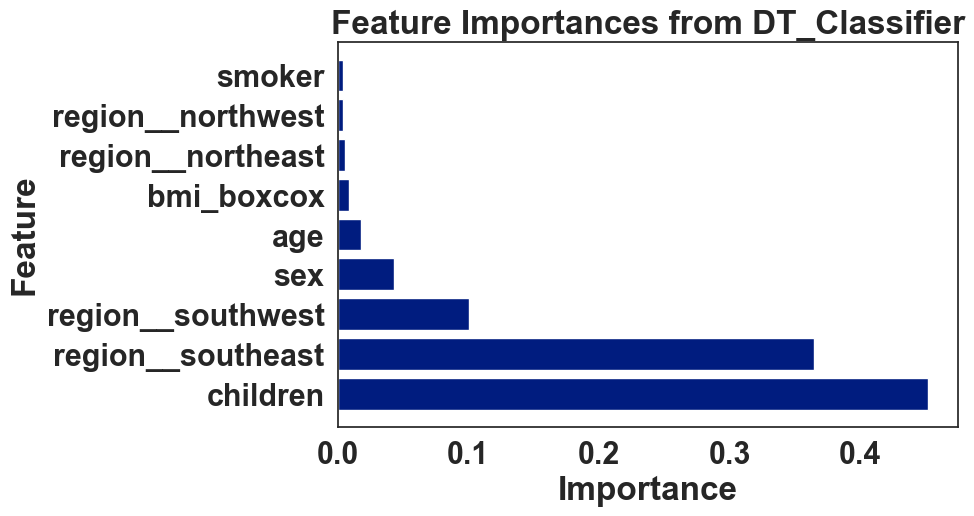

In [80]:
feature_importances = DT_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [81]:
RF_Regressor = RandomForestRegressor(n_estimators=10,random_state=42)
evaluate_model(RF_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


RandomForestRegressor

Training Time: 0.04 seconds

Test Mean Squared Error  -- 0.3960
Train Mean Squared Error  -- 0.0736

Test R2 Score  -- 0.7752
Train R2 Score  -- 0.9609

Test Mean Absolute Error  -- 0.3442
Train Mean Absolute Error  -- 0.1264

Test Median Absolute Error  -- 0.1332
Train Median Absolute Error  -- 0.0308

Test Explained Variance Score  -- 0.7778
Train Explained Variance Score  -- 0.9609

Test Max Error  -- 3.9281
Train Max Error  -- 2.5265

Test Root Mean Squared Error  -- 0.6293
Train Root Mean Squared Error  -- 0.2713

--------------------------------------------------


             Feature  Importance
2           children      0.4495
7  region__southeast      0.3603
8  region__southwest      0.0953
1                sex      0.0593
0                age      0.0127
4         bmi_boxcox      0.0090
5  region__northeast      0.0059
6  region__northwest      0.0043
3             smoker      0.0037


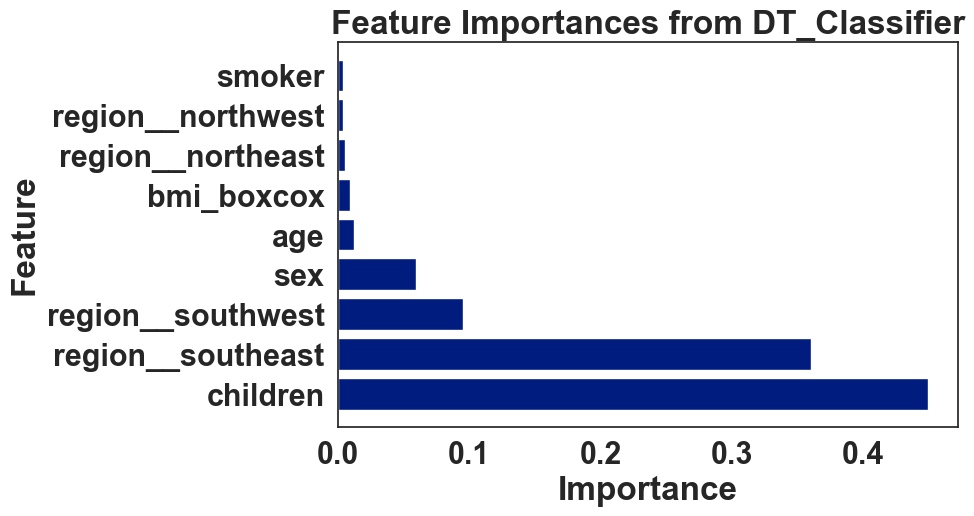

In [82]:
feature_importances = RF_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [111]:
ADA_Regressor = AdaBoostRegressor(random_state=42)
evaluate_model(ADA_Regressor, x_train_scaled_df[aa], y_train, x_test_scaled_df[aa], y_test)


AdaBoostRegressor

Training Time: 0.07 seconds

Test Mean Squared Error  -- 0.4833
Train Mean Squared Error  -- 0.4517

Test R2 Score  -- 0.7257
Train R2 Score  -- 0.7599

Test Mean Absolute Error  -- 0.5250
Train Mean Absolute Error  -- 0.5186

Test Median Absolute Error  -- 0.4233
Train Median Absolute Error  -- 0.4364

Test Explained Variance Score  -- 0.7719
Train Explained Variance Score  -- 0.8031

Test Max Error  -- 2.7910
Train Max Error  -- 2.5489

Test Root Mean Squared Error  -- 0.6952
Train Root Mean Squared Error  -- 0.6721

--------------------------------------------------


             Feature  Importance
7  region__southeast      0.4004
2           children      0.3457
8  region__southwest      0.1327
1                sex      0.0646
0                age      0.0364
5  region__northeast      0.0101
4         bmi_boxcox      0.0100
3             smoker      0.0000
6  region__northwest      0.0000


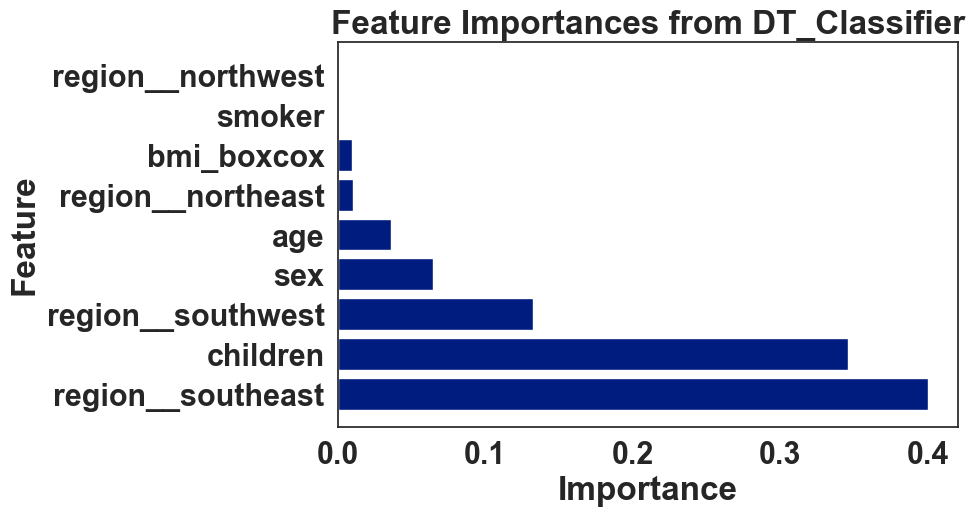

In [84]:
feature_importances = ADA_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [110]:
GB_Regressor = GradientBoostingRegressor(random_state=42)
evaluate_model(GB_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


GradientBoostingRegressor

Training Time: 0.31 seconds

Test Mean Squared Error  -- 0.3116
Train Mean Squared Error  -- 0.2158

Test R2 Score  -- 0.8231
Train R2 Score  -- 0.8853

Test Mean Absolute Error  -- 0.2928
Train Mean Absolute Error  -- 0.2471

Test Median Absolute Error  -- 0.1604
Train Median Absolute Error  -- 0.1283

Test Explained Variance Score  -- 0.8234
Train Explained Variance Score  -- 0.8853

Test Max Error  -- 3.7973
Train Max Error  -- 3.3333

Test Root Mean Squared Error  -- 0.5582
Train Root Mean Squared Error  -- 0.4645

--------------------------------------------------


             Feature  Importance
2           children      0.5081
7  region__southeast      0.3907
8  region__southwest      0.0489
1                sex      0.0358
0                age      0.0080
4         bmi_boxcox      0.0034
3             smoker      0.0032
6  region__northwest      0.0013
5  region__northeast      0.0006


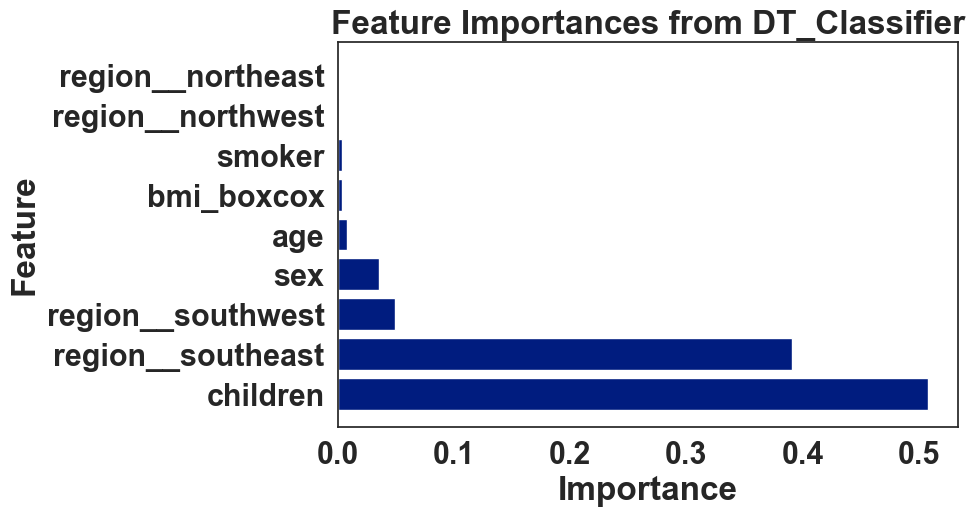

In [86]:
feature_importances = GB_Regressor.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

In [107]:
XGB_Regressor = xg.XGBRegressor(random_state=42)
evaluate_model(XGB_Regressor, x_train_scaled_df.values, y_train, x_test_scaled_df.values, y_test)


XGBRegressor

Training Time: 0.50 seconds

Test Mean Squared Error  -- 0.3936
Train Mean Squared Error  -- 0.0157

Test R2 Score  -- 0.7766
Train R2 Score  -- 0.9916

Test Mean Absolute Error  -- 0.3661
Train Mean Absolute Error  -- 0.0485

Test Median Absolute Error  -- 0.1747
Train Median Absolute Error  -- 0.0240

Test Explained Variance Score  -- 0.7801
Train Explained Variance Score  -- 0.9916

Test Max Error  -- 3.9148
Train Max Error  -- 1.7211

Test Root Mean Squared Error  -- 0.6274
Train Root Mean Squared Error  -- 0.1254

--------------------------------------------------


In [102]:
ET_Regressor = ExtraTreesRegressor(random_state=42)
evaluate_model(ET_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)



ExtraTreesRegressor

Training Time: 0.27 seconds

Test Mean Squared Error  -- 0.4067
Train Mean Squared Error  -- 0.0111

Test R2 Score  -- 0.7692
Train R2 Score  -- 0.9941

Test Mean Absolute Error  -- 0.3137
Train Mean Absolute Error  -- 0.0069

Test Median Absolute Error  -- 0.0839
Train Median Absolute Error  -- 0.0000

Test Explained Variance Score  -- 0.7708
Train Explained Variance Score  -- 0.9941

Test Max Error  -- 3.9857
Train Max Error  -- 1.6614

Test Root Mean Squared Error  -- 0.6377
Train Root Mean Squared Error  -- 0.1053

--------------------------------------------------


In [98]:
params = {'n_neighbors' : list(range(1,22))}

KNN_grid_model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, cv=3, scoring='neg_mean_squared_error',verbose=3, n_jobs=1,error_score='raise')

KNN_grid_model.fit(x_train_scaled_df[aa],y_train)

print(KNN_grid_model.best_params_)


Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV 1/3] END ....................n_neighbors=1;, score=-0.623 total time=   0.0s
[CV 2/3] END ....................n_neighbors=1;, score=-0.766 total time=   0.0s
[CV 3/3] END ....................n_neighbors=1;, score=-0.612 total time=   0.0s
[CV 1/3] END ....................n_neighbors=2;, score=-0.523 total time=   0.0s
[CV 2/3] END ....................n_neighbors=2;, score=-0.544 total time=   0.0s
[CV 3/3] END ....................n_neighbors=2;, score=-0.492 total time=   0.0s
[CV 1/3] END ....................n_neighbors=3;, score=-0.531 total time=   0.0s
[CV 2/3] END ....................n_neighbors=3;, score=-0.510 total time=   0.0s
[CV 3/3] END ....................n_neighbors=3;, score=-0.452 total time=   0.0s
[CV 1/3] END ....................n_neighbors=4;, score=-0.509 total time=   0.0s
[CV 2/3] END ....................n_neighbors=4;, score=-0.434 total time=   0.0s
[CV 3/3] END ....................n_neighbors=4;,

In [99]:
print(f"KNN Best Score - {KNN_grid_model.best_score_}\n\nKNN Best Params - {KNN_grid_model.best_params_}\n\nKNN Best Estimater - {KNN_grid_model.best_estimator_} \n\nKNN Best Index - {KNN_grid_model.best_index_} ")

KNN Best Score - -0.45991885727762916

KNN Best Params - {'n_neighbors': 4}

KNN Best Estimater - KNeighborsRegressor(n_neighbors=4) 

KNN Best Index - 3 


In [96]:
aa = ['age', 'sex', 'children', 'smoker', 'bmi_boxcox', ]

In [100]:
KNN_Regressor = KNeighborsRegressor(n_neighbors=4)
evaluate_model(KNN_Regressor, x_train_scaled_df[aa], y_train, x_test_scaled_df[aa], y_test)



KNeighborsRegressor

Training Time: 0.02 seconds

Test Mean Squared Error  -- 0.4480
Train Mean Squared Error  -- 0.2797

Test R2 Score  -- 0.7457
Train R2 Score  -- 0.8513

Test Mean Absolute Error  -- 0.3954
Train Mean Absolute Error  -- 0.3064

Test Median Absolute Error  -- 0.1920
Train Median Absolute Error  -- 0.1284

Test Explained Variance Score  -- 0.7459
Train Explained Variance Score  -- 0.8514

Test Max Error  -- 3.9006
Train Max Error  -- 3.4366

Test Root Mean Squared Error  -- 0.6694
Train Root Mean Squared Error  -- 0.5288

--------------------------------------------------


In [112]:
np.arange(0.1,3,0.3)

array([0.1, 0.4, 0.7, 1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8])

In [ ]:
GB_Regressor = GradientBoostingRegressor(random_state=42)
evaluate_model(GB_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)

In [118]:
params = {'loss' :['squared_error','absolute_error','huber','quantile'],
          'learning_rate' : np.arange(0.1,3,0.3),
          'subsample' : np.arange(0.1,1.0,0.1),
          'criterion' : ['friedman_mse','squared_error']
        
}

GB_Regressor_grid_model = GridSearchCV(estimator=GradientBoostingRegressor(random_state=33), param_grid=params, cv=3, scoring='neg_mean_squared_error',verbose=3, n_jobs=1,error_score='raise')
GB_Regressor_grid_model.fit(x_train_scaled_df,y_train)

print(GB_Regressor_grid_model.best_params_,'\n',GB_Regressor_grid_model.best_score_)




Fitting 3 folds for each of 720 candidates, totalling 2160 fits
[CV 1/3] END criterion=friedman_mse, learning_rate=0.1, loss=squared_error, subsample=0.1;, score=-0.473 total time=   0.1s
[CV 2/3] END criterion=friedman_mse, learning_rate=0.1, loss=squared_error, subsample=0.1;, score=-0.376 total time=   0.1s
[CV 3/3] END criterion=friedman_mse, learning_rate=0.1, loss=squared_error, subsample=0.1;, score=-0.338 total time=   0.1s
[CV 1/3] END criterion=friedman_mse, learning_rate=0.1, loss=squared_error, subsample=0.2;, score=-0.416 total time=   0.1s
[CV 2/3] END criterion=friedman_mse, learning_rate=0.1, loss=squared_error, subsample=0.2;, score=-0.354 total time=   0.1s
[CV 3/3] END criterion=friedman_mse, learning_rate=0.1, loss=squared_error, subsample=0.2;, score=-0.338 total time=   0.1s
[CV 1/3] END criterion=friedman_mse, learning_rate=0.1, loss=squared_error, subsample=0.30000000000000004;, score=-0.381 total time=   0.1s
[CV 2/3] END criterion=friedman_mse, learning_rate=0

In [119]:
print(GB_Regressor_grid_model.best_params_,'\n',GB_Regressor_grid_model.best_score_)


{'criterion': 'friedman_mse', 'learning_rate': np.float64(0.1), 'loss': 'huber', 'subsample': np.float64(0.7000000000000001)} 
 -0.30690544928515423


In [120]:
GB_Regressor = GradientBoostingRegressor(random_state=42,learning_rate = 0.1,loss = 'huber',subsample=0.7)
evaluate_model(GB_Regressor, x_train_scaled_df, y_train, x_test_scaled_df, y_test)


GradientBoostingRegressor

Training Time: 0.26 seconds

Test Mean Squared Error  -- 0.2920
Train Mean Squared Error  -- 0.2827

Test R2 Score  -- 0.8343
Train R2 Score  -- 0.8497

Test Mean Absolute Error  -- 0.1983
Train Mean Absolute Error  -- 0.1889

Test Median Absolute Error  -- 0.0574
Train Median Absolute Error  -- 0.0485

Test Explained Variance Score  -- 0.8399
Train Explained Variance Score  -- 0.8576

Test Max Error  -- 3.9198
Train Max Error  -- 4.0453

Test Root Mean Squared Error  -- 0.5403
Train Root Mean Squared Error  -- 0.5317

--------------------------------------------------


In [122]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
RF_cv_score = cross_val_score(GB_Regressor,x_train_scaled_df,y_train, cv=kf)
print(f'Cross validations scores \n\n {RF_cv_score}\n\n')
print(f'Cross validations scores mean \n\n {np.mean(RF_cv_score)}')

Cross validations scores 

 [0.84158854 0.83531645 0.79859635 0.88265512 0.8923571  0.84050145
 0.69665512 0.91093735 0.88800966 0.704299  ]


Cross validations scores mean 

 0.829091615702864


In [121]:
os.makedirs('pkls', exist_ok=True)
with open(r'pkls/GB_Regressor.pkl', 'wb') as f:
    pickle.dump(GB_Regressor,f)